# Development notebook for processing sexual dimorphism data

In [327]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import harmonypy as hm

#note 25.03.24 - holoviews import causes bug where no plots are displayed...
#import holoviews as hv
#from holoviews.operation.datashader import datashade
#from holoviews import opts, dim
#from holoviews.operation.datashader import rasterize
#hv.extension('matplotlib')
#from colorcet import fire

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Table of Contents
1. [Introduction](#introduction)
2. [Data Loading](#data_loading)
3. [Filtering](#filtering)
    1. [Cell Exclusion](#cell_exclusion_l1)
    2. [Male vs. Female Gene Expression](#avg_bool_mf_df_sorted_l2)
    3. [Gene Exclusion](#gene_exclusion_l1)
4. [Feature Selection](feat_selection) 
    1. [CV analysis](#get_top_cv_genes)
5. [Preprocessing](#preprocessing) 
    1. [Log and Standerdize](#log_and_standerdize)
6. [Dimensionality Reduction and Integration](#dim_reduction)
    1. [PCA](#analyze_pca)
    2. [Harmony](#harmony)
    2. [t-SNE](#tsne)
        1. [Computing Perplexity](#get_perplexity)
        2. [Visualization](#do_tsne)
        3. [Marker Gene Overlay](#tsne_marker)
7. [Clustering](#clustering)
    1. [DBSCAN](#dbscan)
        1. [Computing Epsilon](#get_epsilon)
        2. [Visualization](#do_dbscan)
8. [Sorting](#cluster_sort)
    1. [Inter Cluster Sorting](#inter_cluster_sort)
    2. [Intra Cluster Sorting](#intra_cluster_sort)
9. [Marker Genes](#markergenes)
    1. [Compute Markers](#compute_marker_genes)
    2. [Heatmap](marker_heatmap)
10. [Cluster/Cell Labeling](#labeling)
    1. [Initialization](#classinit)
    2. [Mean Expression Calculation](#classmean)
    3. [Visualization](#classviz)

## Introduction <a name="introduction"></a>

Analysis notebook for processing sexual dimorphism data. Each processing step calls a function from dimorph_processing.py

## Data Loading <a name="data_loading"></a>

Intialize metadata (meta_data_df), gene expression data (df), boolean gene expression data (df_bool), and status tracking (status_df)

In [328]:
meta_data_df, df_orig, df_bool, status_df = dp.load_data(metadata_file = '/bigdata/isaac/meta_data_dict_040224.json', 
                                                         bigdata_file = '/bigdata/isaac/dimorph_df.feather')

In [329]:
df_orig.shape

(27933, 79613)

In [330]:
df_orig.head()

AAACCCAAGAGCATAT-1_10X51_2  AAACCCAAGCCTCAGC-1_10X51_2  \
gene                                                                    
0610007P14Rik                           0                           2   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           1                           0   
0610010F05Rik                           0                           0   

               AAACCCAAGTACTGTC-1_10X51_2  AAACCCACACAACGTT-1_10X51_2  \
gene                                                                    
0610007P14Rik                           0                           2   
0610009B22Rik                           0                           1   
0610009L18Rik                           0                           0   
0610009O20Rik                           0                           0   
0610010F05Rik                           1                           0   

               AAACCCAGTAACATAG-1_10X51_2  AAACCCATCACTAGCA-1_10X51_2  \
gene                                                                    
0610007P14Rik                           0                           0   
0610009B22Rik                           0                           2   
0610009L18Rik                           0                           0   
0610009O20Rik                           0                           1   
0610010F05Rik                           0                           0   

               AAACGAACACTCCGAG-1_10X51_2  AAACGAACAGCGCGTT-1_10X51_2  \
gene                                                                    
0610007P14Rik                           1                           3   
0610009B22Rik                           2                           0   
0610009L18Rik                           1                           1   
0610009O20Rik                           1                           0   
0610010F05Rik                           2                           1   

               AAACGAACAGGACTTT-1_10X51_2  AAACGAAGTGAATAAC-1_10X51_2  ...  \
gene                                                                   ...   
0610007P14Rik                           2                           0  ...   
0610009B22Rik                           1                           0  ...   
0610009L18Rik                           0                           0  ...   
0610009O20Rik                           0                           0  ...   
0610010F05Rik                           1                           0  ...   

               TTTGGTTTCCACGAAT-1_10X37_2  TTTGGTTTCTTTCTAG-1_10X37_2  \
gene                                                                    
0610007P14Rik                           1                           0   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           0                           0   
0610010F05Rik                           1                           0   

               TTTGTTGAGAAATTCG-1_10X37_2  TTTGTTGAGTGCTCGC-1_10X37_2  \
gene                                                                    
0610007P14Rik                           1                           0   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           0                           0   
0610010F05Rik                           2                           0   

               TTTGTTGCAAGGTCAG-1_10X37_2  TTTGTTGCACCGCTGA-1_10X37_2  \
gene                                                                    
0610007P14Rik                           2                           1   
0610009B22Rik                           2                           0   
0610009L18Rik                           1                           0   
0610009O20Rik                  

In [331]:
meta_data_df.shape

(27, 79613)

In [332]:
meta_data_df.head()

AAACCCAAGAGCATAT-1_10X51_2 AAACCCAAGCCTCAGC-1_10X51_2  \
Serial_Number                       98.0                       98.0   
Date_Captured                   05/31/20                   05/31/20   
Species                               Mm                         Mm   
Transcriptome                       Mm10                       Mm10   
Strain                           C57Bl/6                    C57Bl/6   

              AAACCCAAGTACTGTC-1_10X51_2 AAACCCACACAACGTT-1_10X51_2  \
Serial_Number                       98.0                       98.0   
Date_Captured                   05/31/20                   05/31/20   
Species                               Mm                         Mm   
Transcriptome                       Mm10                       Mm10   
Strain                           C57Bl/6                    C57Bl/6   

              AAACCCAGTAACATAG-1_10X51_2 AAACCCATCACTAGCA-1_10X51_2  \
Serial_Number                       98.0                       98.0   
Date_Captured                   05/31/20                   05/31/20   
Species                               Mm                         Mm   
Transcriptome                       Mm10                       Mm10   
Strain                           C57Bl/6                    C57Bl/6   

              AAACGAACACTCCGAG-1_10X51_2 AAACGAACAGCGCGTT-1_10X51_2  \
Serial_Number                       98.0                       98.0   
Date_Captured                   05/31/20                   05/31/20   
Species                               Mm                         Mm   
Transcriptome                       Mm10                       Mm10   
Strain                           C57Bl/6                    C57Bl/6   

              AAACGAACAGGACTTT-1_10X51_2 AAACGAAGTGAATAAC-1_10X51_2  ...  \
Serial_Number                       98.0                       98.0  ...   
Date_Captured                   05/31/20                   05/31/20  ...   
Species                               Mm                         Mm  ...   
Transcriptome                       Mm10                       Mm10  ...   
Strain                           C57Bl/6                    C57Bl/6  ...   

              TTTGGTTTCCACGAAT-1_10X37_2 TTTGGTTTCTTTCTAG-1_10X37_2  \
Serial_Number                       68.0                       68.0   
Date_Captured                 2019-11-25                 2019-11-25   
Species                               Mm                         Mm   
Transcriptome                       Mm10                       Mm10   
Strain                                                                

              TTTGTTGAGAAATTCG-1_10X37_2 TTTGTTGAGTGCTCGC-1_10X37_2  \
Serial_Number                       68.0                       68.0   
Date_Captured                 2019-11-25                 2019-11-25   
Species                               Mm                         Mm   
Transcriptome                       Mm10                       Mm10   
Strain                                                                

              TTTGTTGCAAGGTCAG-1_10X37_2 TTTGTTGCACCGCTGA-1_10X37_2  \
Serial_Number                       68.0                       68.0   
Date_Captured                 2019-11-25                 2019-11-25   
Species                               Mm                         Mm   
Transcriptome                       Mm10                       Mm10   
Strain                                                                

              TTTGTTGGTCCATAGT-1_10X37_2 TTTGTTGGTTGCGAAG-1_10X37_2  \
Serial_Number                       68.0                       68.0   
Date_Captured                 2019-11-25                 2019-11-25   
Species                               Mm                         Mm   
Transcriptome                       Mm10                       Mm10   
Strain                                                                

              TTTGTTGTCGAAGGAC-1_10X37_2 TTTGTTGTCTCTGCTG-1_10X37_2  
Serial_Number                       68.0                       68.0  
D

Histogram of total counts per cell

<IPython.core.display.Javascript object>


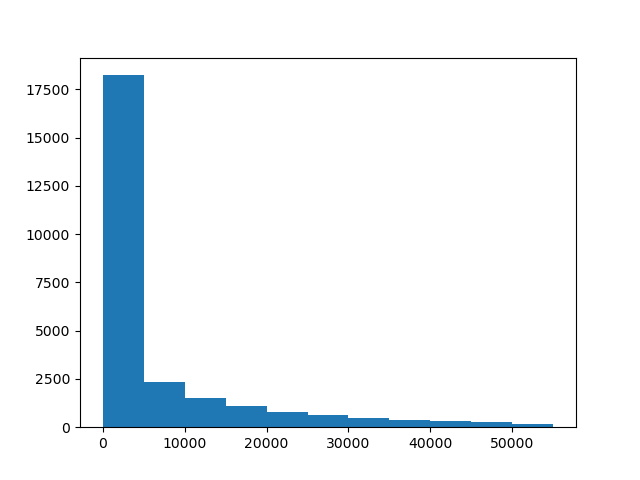

In [333]:
plt.figure()
plt.hist(np.array(df_orig.sum(axis = 1)),bins = np.arange(0,60000, 5000))
plt.show()

In [334]:
status_df

completion_status
cell_exclusion (l1)               NaN
gene_exclusion (l1)               NaN
get_top_cv_genes                  NaN
log_and_standerdize               NaN
analyze_pca                       NaN
get_perplexity                    NaN
do_tsne                           NaN
compute_eps                       NaN
do_dbscan                         NaN

## Filtering <a name="filtering"></a>

### Cell Exclusion <a name="cell_exclusion_l1"></a>

Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [335]:
df, df_bool, meta_data_df, status_df = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      meta_data_df = meta_data_df,
                                                      df_bool = df_bool,
                                                      df = df_orig,
                                                      status_df = status_df)


Total cells reduced from 79613 to 43492


In [336]:
df.head()

AAACCCAAGAGCATAT-1_10X51_2  AAACCCAAGCCTCAGC-1_10X51_2  \
gene                                                                    
0610007P14Rik                           0                           2   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           1                           0   
0610010F05Rik                           0                           0   

               AAACCCACACAACGTT-1_10X51_2  AAACCCATCACTAGCA-1_10X51_2  \
gene                                                                    
0610007P14Rik                           2                           0   
0610009B22Rik                           1                           2   
0610009L18Rik                           0                           0   
0610009O20Rik                           0                           1   
0610010F05Rik                           0                           0   

               AAACGAACACTCCGAG-1_10X51_2  AAACGAACAGCGCGTT-1_10X51_2  \
gene                                                                    
0610007P14Rik                           1                           3   
0610009B22Rik                           2                           0   
0610009L18Rik                           1                           1   
0610009O20Rik                           1                           0   
0610010F05Rik                           2                           1   

               AAACGAACAGGACTTT-1_10X51_2  AAACGAAGTGAATAAC-1_10X51_2  \
gene                                                                    
0610007P14Rik                           2                           0   
0610009B22Rik                           1                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           0                           0   
0610010F05Rik                           1                           0   

               AAACGAAGTGACCTGC-1_10X51_2  AAACGCTAGCTCACTA-1_10X51_2  ...  \
gene                                                                   ...   
0610007P14Rik                           1                           1  ...   
0610009B22Rik                           0                           0  ...   
0610009L18Rik                           0                           0  ...   
0610009O20Rik                           0                           0  ...   
0610010F05Rik                           0                           0  ...   

               TTTGGAGGTGTGTCCG-1_10X37_2  TTTGGAGTCTCGCTTG-1_10X37_2  \
gene                                                                    
0610007P14Rik                           0                           1   
0610009B22Rik                           1                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           1                           0   
0610010F05Rik                           1                           0   

               TTTGGTTTCCAATCTT-1_10X37_2  TTTGGTTTCCACGAAT-1_10X37_2  \
gene                                                                    
0610007P14Rik                           1                           1   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           1                           0   
0610010F05Rik                           0                           1   

               TTTGGTTTCTTTCTAG-1_10X37_2  TTTGTTGAGAAATTCG-1_10X37_2  \
gene                                                                    
0610007P14Rik                           0                           1   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                  

In [337]:
df.shape #rerun

(27933, 43492)

In [338]:
status_df

completion_status
cell_exclusion (l1)              True
gene_exclusion (l1)               NaN
get_top_cv_genes                  NaN
log_and_standerdize               NaN
analyze_pca                       NaN
get_perplexity                    NaN
do_tsne                           NaN
compute_eps                       NaN
do_dbscan                         NaN

Sanity Check of known specific sex genes

In [339]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

True
True
True
True
True
True


### Male vs. Female Gene Expression <a name="avg_bool_mf_df_sorted_l2"></a>

num m cells: 19749 num f cells: 23743


<IPython.core.display.Javascript object>


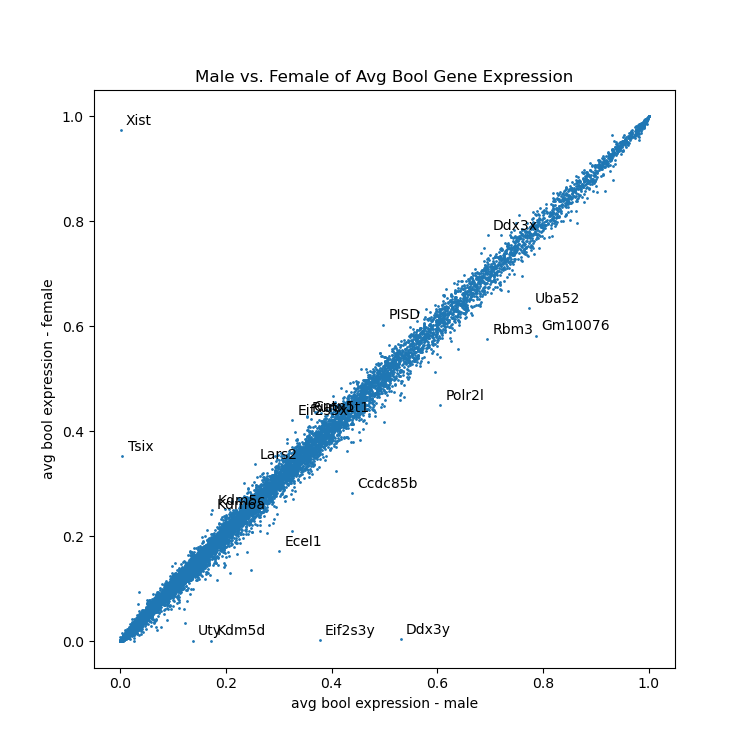

In [340]:
%matplotlib notebook
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = df_bool,
                                                              meta_data_df=meta_data_df,
                                                             num_top_genes=10,
                                                             plot_flag=1)

### Gene Exclusion <a name="gene_exclusion_l1"></a> 

Keep only genes expressed in >10 cells, <50% of all cells

In [341]:
df, df_bool, meta_data_df, status_df = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=df_bool,
                                                     df = df,
                                                     meta_data_df = meta_data_df,
                                                     status_df = status_df)
df.head()

Total genes reduced from 27933 to 17081


AAACCCAAGAGCATAT-1_10X51_2  AAACCCAAGCCTCAGC-1_10X51_2  \
gene                                                                    
0610007P14Rik                           0                           2   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           1                           0   
0610010F05Rik                           0                           0   

               AAACCCACACAACGTT-1_10X51_2  AAACCCATCACTAGCA-1_10X51_2  \
gene                                                                    
0610007P14Rik                           2                           0   
0610009B22Rik                           1                           2   
0610009L18Rik                           0                           0   
0610009O20Rik                           0                           1   
0610010F05Rik                           0                           0   

               AAACGAACACTCCGAG-1_10X51_2  AAACGAACAGCGCGTT-1_10X51_2  \
gene                                                                    
0610007P14Rik                           1                           3   
0610009B22Rik                           2                           0   
0610009L18Rik                           1                           1   
0610009O20Rik                           1                           0   
0610010F05Rik                           2                           1   

               AAACGAACAGGACTTT-1_10X51_2  AAACGAAGTGAATAAC-1_10X51_2  \
gene                                                                    
0610007P14Rik                           2                           0   
0610009B22Rik                           1                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           0                           0   
0610010F05Rik                           1                           0   

               AAACGAAGTGACCTGC-1_10X51_2  AAACGCTAGCTCACTA-1_10X51_2  ...  \
gene                                                                   ...   
0610007P14Rik                           1                           1  ...   
0610009B22Rik                           0                           0  ...   
0610009L18Rik                           0                           0  ...   
0610009O20Rik                           0                           0  ...   
0610010F05Rik                           0                           0  ...   

               TTTGGAGGTGTGTCCG-1_10X37_2  TTTGGAGTCTCGCTTG-1_10X37_2  \
gene                                                                    
0610007P14Rik                           0                           1   
0610009B22Rik                           1                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           1                           0   
0610010F05Rik                           1                           0   

               TTTGGTTTCCAATCTT-1_10X37_2  TTTGGTTTCCACGAAT-1_10X37_2  \
gene                                                                    
0610007P14Rik                           1                           1   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                           1                           0   
0610010F05Rik                           0                           1   

               TTTGGTTTCTTTCTAG-1_10X37_2  TTTGTTGAGAAATTCG-1_10X37_2  \
gene                                                                    
0610007P14Rik                           0                           1   
0610009B22Rik                           0                           0   
0610009L18Rik                           0                           0   
0610009O20Rik                  

In [342]:
meta_data_df.shape

(27, 43492)

In [343]:
df.shape

(17081, 43492)

In [344]:
status_df

completion_status
cell_exclusion (l1)              True
gene_exclusion (l1)              True
get_top_cv_genes                  NaN
log_and_standerdize               NaN
analyze_pca                       NaN
get_perplexity                    NaN
do_tsne                           NaN
compute_eps                       NaN
do_dbscan                         NaN

#### Sanity Check of known specific sex genes

In [345]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

False
True
True
True
True
True


## Feature Selection <a name="feat_selection"></a> 

### CV Analysis <a name="get_top_cv_genes"></a> 

<IPython.core.display.Javascript object>


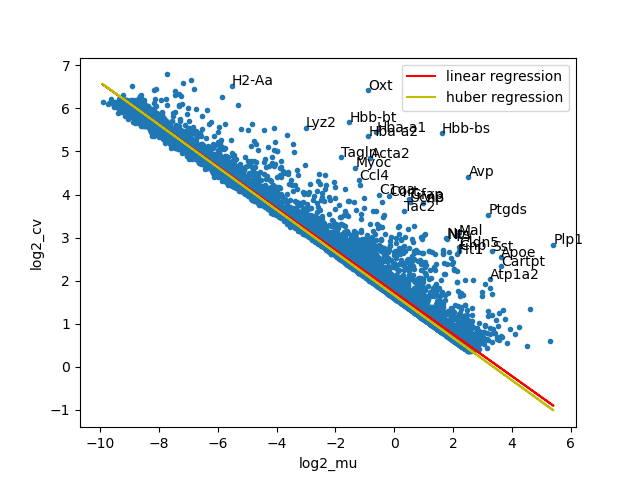

In [346]:
cv_df = dp.analyze_cv(df = df,
                      norm_scale_factor=20000,
                      num_top_genes=30,
                      plot_flag=1,
                     use_huber = True)

In [347]:
cv_df.head()

log2mu    log2cv  delta_cv
gene                                
Hbb-bs  1.620289  5.429946  4.570352
Oxt    -0.879842  6.428204  4.330631
Avp     2.526425  4.414903  4.003995
Plp1    5.415903  2.831623  3.851485
Hba-a1 -0.615138  5.448019  3.481519

In [348]:
cv_df.shape

(17081, 3)

Use highest variation CV genes to get top genes

<IPython.core.display.Javascript object>


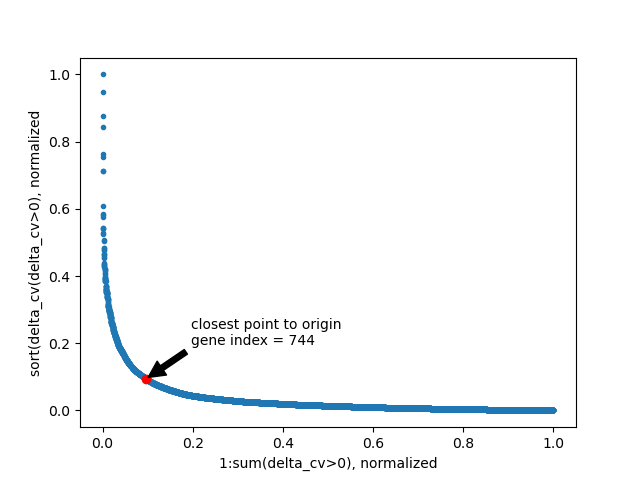

In [349]:
gene_index, df, status_df = dp.get_top_cv_genes(df = df, cv_df=cv_df, plot_flag=1, status_df=status_df)

In [350]:
df.shape

(744, 43492)

In [351]:
gene_index

744

In [352]:
status_df

completion_status
cell_exclusion (l1)              True
gene_exclusion (l1)              True
get_top_cv_genes                 True
log_and_standerdize               NaN
analyze_pca                       NaN
get_perplexity                    NaN
do_tsne                           NaN
compute_eps                       NaN
do_dbscan                         NaN

utilize mean-variance relationship (PCA). Why this as opposed t mean-dropout relationship? see 'feature selection' section in :
https://www.nature.com/articles/s41467-019-13056-x

## Preprocessing <a name="preprocessing"></a> 

### Log and Standerdize <a name="#log_and_standerdize"></a> 

In [353]:
df.head()

AAACCCAAGAGCATAT-1_10X51_2  AAACCCAAGCCTCAGC-1_10X51_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           0   
Hba-a1                           0                           0   

        AAACCCACACAACGTT-1_10X51_2  AAACCCATCACTAGCA-1_10X51_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           1   
Plp1                             2                           0   
Hba-a1                           0                           0   

        AAACGAACACTCCGAG-1_10X51_2  AAACGAACAGCGCGTT-1_10X51_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           0   
Hba-a1                           0                           0   

        AAACGAACAGGACTTT-1_10X51_2  AAACGAAGTGAATAAC-1_10X51_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              1                           0   
Plp1                             1                           0   
Hba-a1                           0                           0   

        AAACGAAGTGACCTGC-1_10X51_2  AAACGCTAGCTCACTA-1_10X51_2  ...  \
gene                                                            ...   
Hbb-bs                           0                           0  ...   
Oxt                              0                           0  ...   
Avp                              0                           0  ...   
Plp1                             0                           0  ...   
Hba-a1                           0                           0  ...   

        TTTGGAGGTGTGTCCG-1_10X37_2  TTTGGAGTCTCGCTTG-1_10X37_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             1                           0   
Hba-a1                           0                           0   

        TTTGGTTTCCAATCTT-1_10X37_2  TTTGGTTTCCACGAAT-1_10X37_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           1   
Hba-a1                           0                           0   

        TTTGGTTTCTTTCTAG-1_10X37_2  TTTGTTGAGAAATTCG-1_10X37_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                          71   
Hba-a1                           0                           0   

        TTTGTTGCAAGGTCAG-1_10X37_2  TTTGTTGCACCGCTGA-1_10X37_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp  

In [354]:
df.shape

(744, 43492)

In [355]:
log_std_arr,status_df = dp.log_and_standerdize_df(df,status_df)

column (gene) mean after standardization: 0.00
column (gene) sigma after standardization: 1.00


In [356]:
log_std_arr.shape

(43492, 744)

In [357]:
log_std_arr.shape

(43492, 744)

In [358]:
status_df

completion_status
cell_exclusion (l1)              True
gene_exclusion (l1)              True
get_top_cv_genes                 True
log_and_standerdize              True
analyze_pca                       NaN
get_perplexity                    NaN
do_tsne                           NaN
compute_eps                       NaN
do_dbscan                         NaN

Create log/standerdized version of df to use in inter cluster sorting alg later

In [360]:
df_ls = pd.DataFrame(data = log_std_arr.T, index = df.index, columns=df.columns)

## Dimensionality Reduction <a name="dim_reduction"></a> 

### PCA <a name="analyze_pca"></a> 

Do PCA intially with num components = all genes, use normalized explained variance to select highest variation PCs and reduce gene expression to this dimension 

<IPython.core.display.Javascript object>


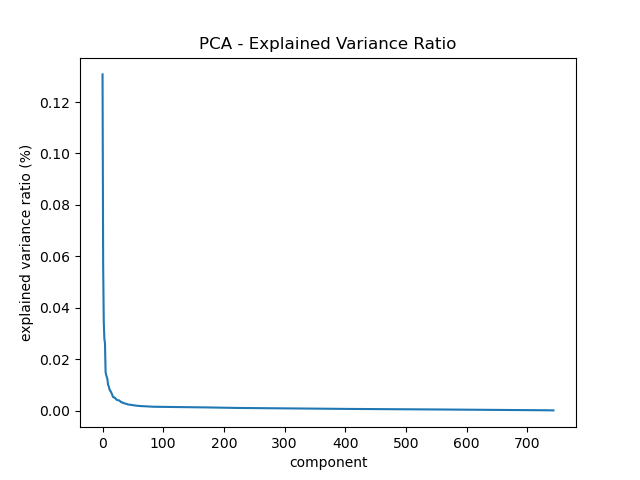

<IPython.core.display.Javascript object>


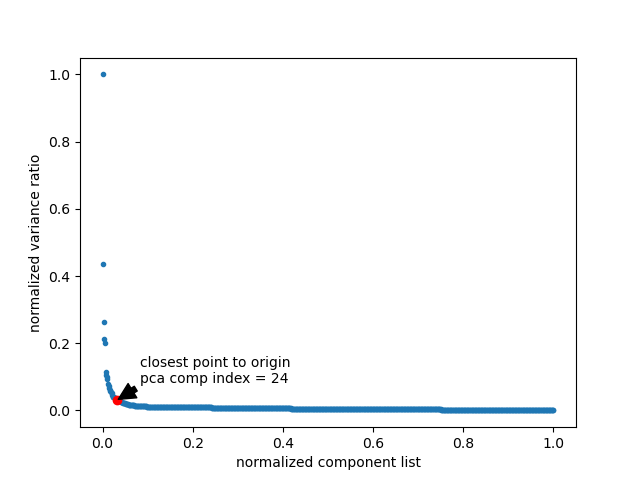

<IPython.core.display.Javascript object>


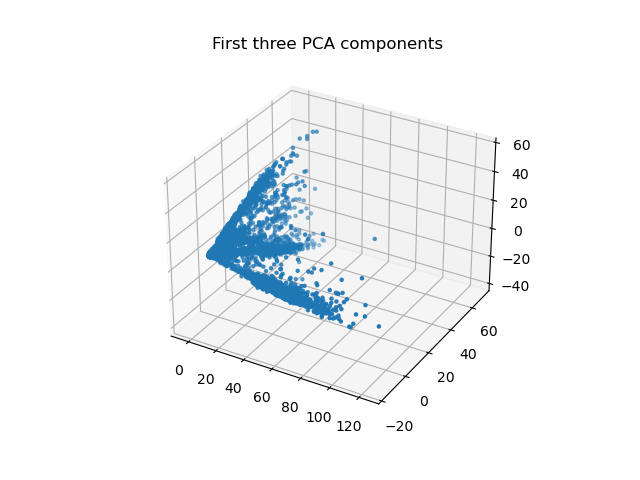

In [239]:
pca_index, arr_pca, status_df = dp.analyze_pca(arr = log_std_arr, #log_std_arr
                                               n_components=log_std_arr.shape[1], #log_std_arr.shape[1]
                                               optimize_n=True,
                                               plot_flag=1, 
                                               status_df=status_df)

In [240]:
arr_pca.shape

(43492, 24)

In [241]:
pca_index

24

In [242]:
status_df

completion_status
cell_exclusion (l1)              True
gene_exclusion (l1)              True
get_top_cv_genes                 True
log_and_standerdize              True
analyze_pca                      True
get_perplexity                    NaN
do_tsne                           NaN
compute_eps                       NaN
do_dbscan                         NaN

In [243]:
'Apoe' in df.index

True

Create copy of meta data to use for Harmony

In [244]:
meta_data_df.shape

(27, 43492)

In [245]:
meta_data_df.index

Index(['Serial_Number', 'Date_Captured', 'Species', 'Transcriptome', 'Strain',
       'Project', 'Group', 'ChipID', 'SampleID', 'DonorID', 'Age',
       'Num_Pooled_Animals', 'Sex', 'Tissue', 'Cell_Conc', 'Target_Num_Cells',
       'PCR_Cycles', 'Comments', 'cDNA_Lib_Ok', 'ngperul_cDNA',
       'Avesizebp_cDNAlib', 'Date', 'cDNAul', 'LIbConstructionComment',
       'ngperul_seqlib', 'lengthbp_seqlib', 'Sample_Index'],
      dtype='object')

In [251]:
meta_data_df_pca = meta_data_df.T.copy()

### Harmony Cell Integration <a name="harmony"></a> 

In [248]:
arr_pca.shape

(43492, 24)

In [252]:
meta_data_df_pca.shape

(43492, 27)

In [255]:
meta_data_df_pca.columns

Index(['Serial_Number', 'Date_Captured', 'Species', 'Transcriptome', 'Strain',
       'Project', 'Group', 'ChipID', 'SampleID', 'DonorID', 'Age',
       'Num_Pooled_Animals', 'Sex', 'Tissue', 'Cell_Conc', 'Target_Num_Cells',
       'PCR_Cycles', 'Comments', 'cDNA_Lib_Ok', 'ngperul_cDNA',
       'Avesizebp_cDNAlib', 'Date', 'cDNAul', 'LIbConstructionComment',
       'ngperul_seqlib', 'lengthbp_seqlib', 'Sample_Index'],
      dtype='object')

In [256]:
vars_use = ['SampleID']

In [259]:
ho = hm.run_harmony(arr_pca,meta_data_df_pca,vars_use)

2024-04-07 15:46:24,028 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-07 15:46:26,643 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-07 15:46:26,891 - harmonypy - INFO - Iteration 1 of 10
2024-04-07 15:46:38,984 - harmonypy - INFO - Iteration 2 of 10
2024-04-07 15:46:51,159 - harmonypy - INFO - Iteration 3 of 10
2024-04-07 15:47:03,280 - harmonypy - INFO - Iteration 4 of 10
2024-04-07 15:47:15,331 - harmonypy - INFO - Iteration 5 of 10
2024-04-07 15:47:27,387 - harmonypy - INFO - Iteration 6 of 10
2024-04-07 15:47:35,549 - harmonypy - INFO - Converged after 6 iterations


In [265]:
ho.Z_corr.T.shape

(43492, 24)

In [266]:
hm_arr = ho.Z_corr.T

### t-SNE <a name="tsne"></a> 

#### Computing Perplexity <a name="get_perplexity"></a> 

Amit's method for determining perplexity param - 
1) compute pairwise distance matrix (n_cells x n_cells) from PCA reduced matrix.
2) sort columns by ascending values
3) compute angle from first point to last point of column values from index 1-500
4) use rotation matrix to rotate column values by this angle
5) take argmax for each rotated set of column values and store in list
6) take median of list created in step 5, this is perplexity value



Updated 7 Apr 2024 - use harmonized array (hm_arr) instead of pca array (pca_arr) as input, perplexity param adjusted from 57 to 56

<IPython.core.display.Javascript object>


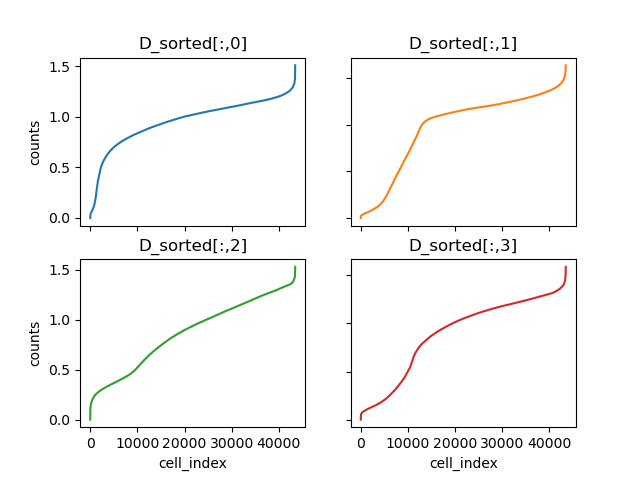

<IPython.core.display.Javascript object>


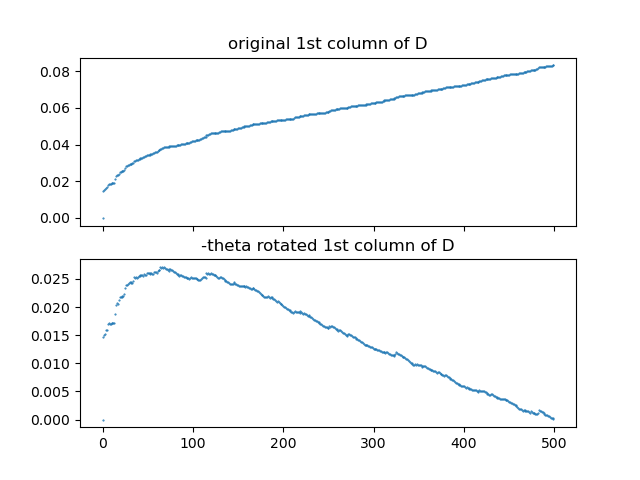

In [267]:
perplexity,status_df = dp.get_perplexity(pca_arr = hm_arr, cutoff=500, plot_flag=1, status_df = status_df)

In [268]:
perplexity

56.0

In [40]:
status_df

completion_status
cell_exclusion (l1)              True
gene_exclusion (l1)              True
get_top_cv_genes                 True
log_and_standerdize              True
analyze_pca                      True
get_perplexity                   True
do_tsne                           NaN
compute_eps                       NaN
do_dbscan                         NaN

#### Visualize with t-SNE<a name="do_tsne"></a> 

In [41]:
arr_pca.shape

(43492, 24)

In [269]:
hm_arr.shape

(43492, 24)

Update 7 Apr 2024 - use harmonized array

Do TSNE on pca reduced, harmonized matrix using calculated perplexity. See https://www.nature.com/articles/s41467-019-13056-x for more details on parameter selection.

Note sklearn's learning rate is defined factor of 4 smaller than other implementations, see sklearn doc: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Create a t-SNE object

creating tsne object with the following parameters: 
n_components:2
n_iter: 1000
learning_rate: 50
early_exaggeration: 12
init: pca
perplexity: 56.0


<IPython.core.display.Javascript object>


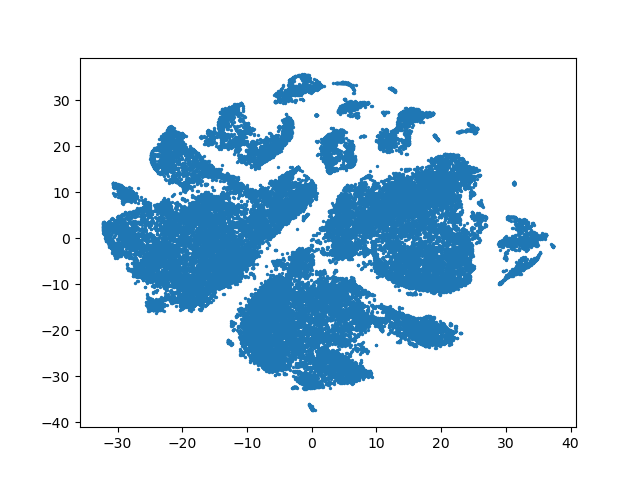

In [270]:
arr_tsne,status_df = dp.do_tsne(arr = hm_arr, 
                               n_components=2,
                               n_iter=1000,
                               learning_rate=50,
                               early_exaggeration=12,
                               init='pca', 
                               perplexity = perplexity,
                               status_df = status_df)

creating tsne object with the following parameters: 
n_components:2
n_iter: 1000
learning_rate: 50
early_exaggeration: 12
init: pca
perplexity: 57.0


<IPython.core.display.Javascript object>


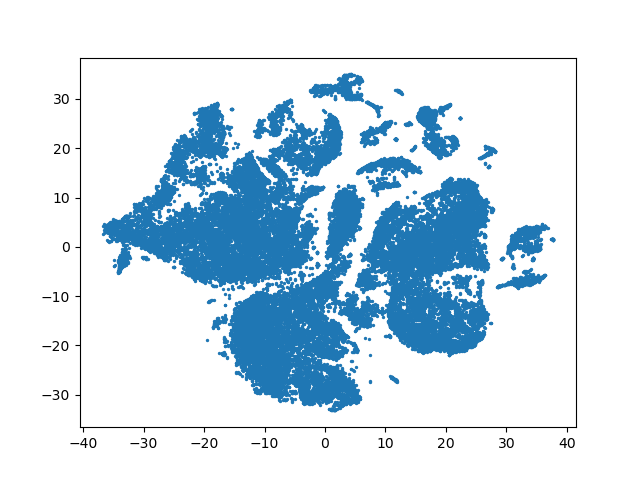

In [42]:
arr_tsne,status_df = dp.do_tsne(arr = arr_pca, 
                               n_components=2,
                               n_iter=1000,
                               learning_rate=50,
                               early_exaggeration=12,
                               init='pca', 
                               perplexity = perplexity,
                               status_df = status_df)

In [43]:
arr_tsne.shape

(43492, 2)

In [44]:
status_df

completion_status
cell_exclusion (l1)              True
gene_exclusion (l1)              True
get_top_cv_genes                 True
log_and_standerdize              True
analyze_pca                      True
get_perplexity                   True
do_tsne                          True
compute_eps                       NaN
do_dbscan                         NaN

#### Overlay tSNE with known marker genes <a name="tsne_marker"></a> 

As a sanity check, plot a positively expressed known marker gene on top of tSNE plot.
Known marker genes from: 
https://www.science.org/doi/full/10.1126/science.aaa1934)

In [45]:
tsne = TSNE(n_components=2,
            n_iter=1000,
            learning_rate=50,
           early_exaggeration=12,
           init='pca', 
           perplexity = perplexity)

# Apply t-SNE on the arr
X_tsne = tsne.fit_transform(arr_pca)

In [46]:
#Mpb, Gad1, Aldoc, Cldn5(good), Acta2 (good)

gene in df?  True
gene index:  [61]
num cells with positive expression of gene, Snca: 188


<IPython.core.display.Javascript object>


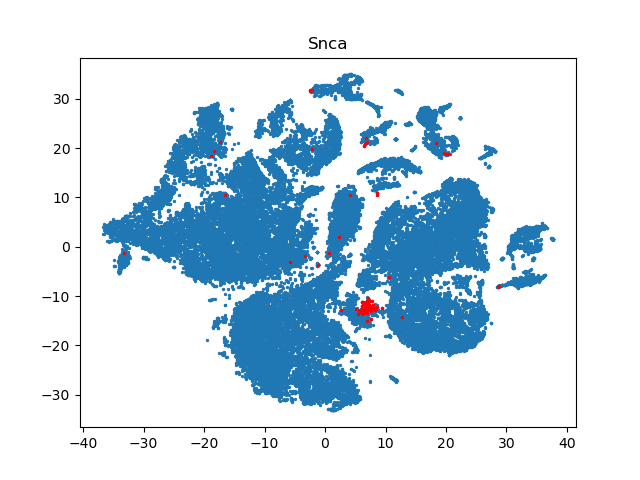

In [47]:
gene = 'Snca'
print('gene in df? ', gene in df.index)
print ('gene index: ', np.where(df.index == gene)[0])

#boolean array where True = gene postively expressed
x = df.iloc[np.where(df.index == gene)[0],:]>0
       
x_arr = x.to_numpy()
#use array of cell names to get cell index       
result = [idx for idx, val in enumerate(df.columns) if val in df.columns[x_arr[0]]]
print (f'num cells with positive expression of gene, {gene}:', len(result))

#visualise tsne
ax, fig = plt.subplots()
plt.title(gene)
fig.scatter(X_tsne[:, 0], X_tsne[:, 1], s = 2)
fig.scatter(X_tsne[result,0], X_tsne[result,1], s = 2, c = 'r')
plt.show()

Compared with hm_arr tSNE input...

gene in df?  True
gene index:  [61]
num cells with positive expression of gene, Snca: 188


<IPython.core.display.Javascript object>


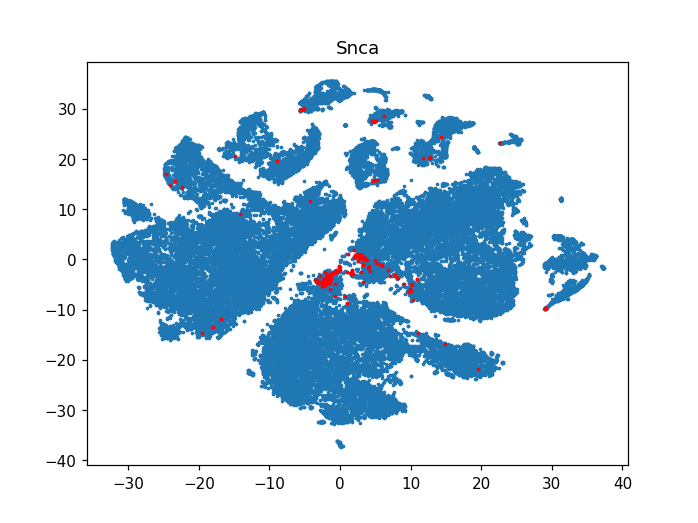

In [961]:
gene = 'Snca'
print('gene in df? ', gene in df.index)
print ('gene index: ', np.where(df.index == gene)[0])

#boolean array where True = gene postively expressed
x = df.iloc[np.where(df.index == gene)[0],:]>0
       
x_arr = x.to_numpy()
#use array of cell names to get cell index       
result = [idx for idx, val in enumerate(df.columns) if val in df.columns[x_arr[0]]]
print (f'num cells with positive expression of gene, {gene}:', len(result))

#visualise tsne
ax, fig = plt.subplots()
plt.title(gene)
fig.scatter(arr_tsne[:, 0], arr_tsne[:, 1], s = 2)
fig.scatter(arr_tsne[result,0], arr_tsne[result,1], s = 2, c = 'r')
plt.show()

In [984]:
df.shape

(744, 43492)

In [972]:
arr_tsne.shape

(43492, 2)

In [981]:
arr_tsne.shape

(43492, 2)

In [982]:
arr_df.shape

(42764, 3)

gene in df?  True
gene index:  [80]


<IPython.core.display.Javascript object>


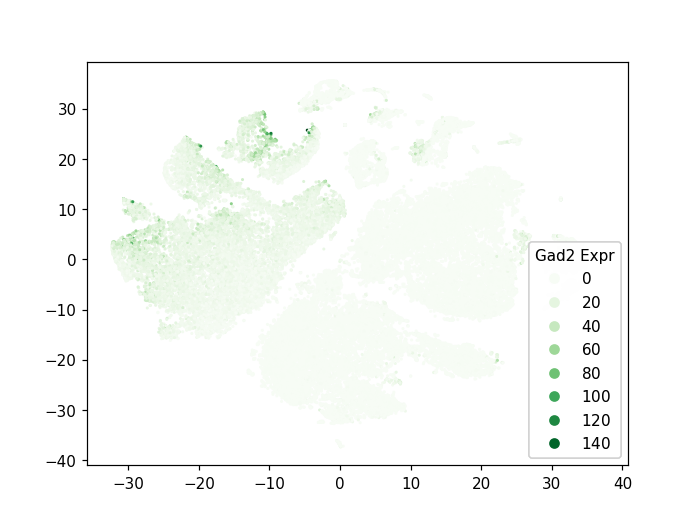

In [986]:
#plot actual expression values of a maker instead of using boolean condition
gene = 'Gad2'
print('gene in df? ', gene in df.index)
print ('gene index: ', np.where(df.index == gene)[0])

x = arr_tsne[:, 0]
y = arr_tsne[:, 1]
z = np.array(df.loc[gene,:])

#boolean array where True = gene postively expressed
#x = df.iloc[np.where(df.index == gene)[0],:]>0
       
#x_arr = x.to_numpy()
#use array of cell names to get cell index       
#result = [idx for idx, val in enumerate(df.columns) if val in df.columns[x_arr[0]]]
#print (f'num cells with positive expression of gene, {gene}:', len(result))

#visualise tsne
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c = z , cmap = 'Greens' , s = 1)
legend = ax.legend(*scatter.legend_elements(), loc="lower right",
                   title= gene + " Expr")
ax.add_artist(legend)
plt.show()



#fig.scatter(arr_tsne[result,0], arr_tsne[result,1], s = 2, c = 'r')
plt.show()

In [639]:
x

AAACCCAAGAGCATAT-1_10X51_2  AAACCCAAGCCTCAGC-1_10X51_2  \
gene                                                           
Snca                       False                       False   

      AAACCCACACAACGTT-1_10X51_2  AAACCCATCACTAGCA-1_10X51_2  \
gene                                                           
Snca                       False                       False   

      AAACGAACACTCCGAG-1_10X51_2  AAACGAACAGCGCGTT-1_10X51_2  \
gene                                                           
Snca                       False                       False   

      AAACGAACAGGACTTT-1_10X51_2  AAACGAAGTGAATAAC-1_10X51_2  \
gene                                                           
Snca                       False                       False   

      AAACGAAGTGACCTGC-1_10X51_2  AAACGCTAGCTCACTA-1_10X51_2  ...  \
gene                                                          ...   
Snca                       False                       False  ...   

      TTTGGAGGTGTGTCCG-1_10X37_2  TTTGGAGTCTCGCTTG-1_10X37_2  \
gene                                                           
Snca                       False                       False   

      TTTGGTTTCCAATCTT-1_10X37_2  TTTGGTTTCCACGAAT-1_10X37_2  \
gene                                                           
Snca                       False                       False   

      TTTGGTTTCTTTCTAG-1_10X37_2  TTTGTTGAGAAATTCG-1_10X37_2  \
gene                                                           
Snca                       False                       False   

      TTTGTTGCAAGGTCAG-1_10X37_2  TTTGTTGCACCGCTGA-1_10X37_2  \
gene                                                           
Snca                       False                       False   

      TTTGTTGGTCCATAGT-1_10X37_2  TTTGTTGGTTGCGAAG-1_10X37_2  
gene                                                          
Snca                       False                       False  

[1 rows x 43492 columns]

In [48]:
status_df

completion_status
cell_exclusion (l1)              True
gene_exclusion (l1)              True
get_top_cv_genes                 True
log_and_standerdize              True
analyze_pca                      True
get_perplexity                   True
do_tsne                          True
compute_eps                       NaN
do_dbscan                         NaN

## Clustering <a name="clustering"></a>

### DBSCAN <a name="dbscan"></a>

#### Computing Epsilon <a name="get_epsilon"></a> 

In [273]:
epsilon, minpts, status_df = dp.compute_eps(minpts = 35, eps_prc=90, arr= arr_tsne, status_df = status_df)

params for dbscan
minpts:  35
epsilon:  0.9342714289900461



Alternative method for finding epsilon- calculate avg distance between each point and its n_neighbors (equal to min_pts), plot, and select point of max curvature 

In [274]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(arr_tsne)
distances, indices = neighbors_fit.kneighbors(arr_tsne)

<IPython.core.display.Javascript object>


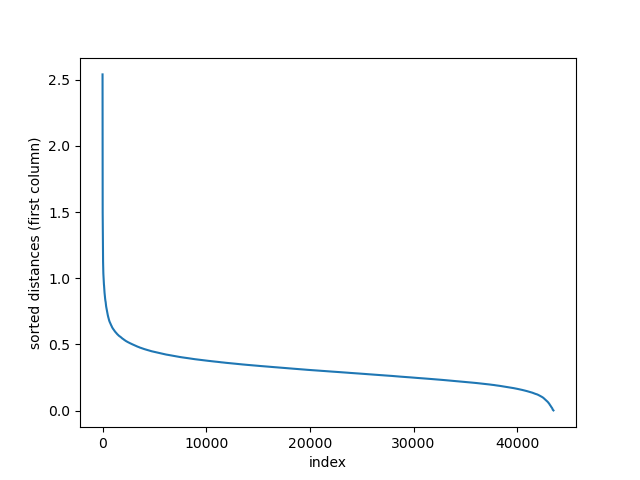

In [275]:
distances = np.flip(np.sort(distances, axis=0))
distances_c1 = distances[:,1]
fig,ax = plt.subplots()
plt.plot(distances_c1)
plt.xlabel('index')
plt.ylabel('sorted distances (first column)')
plt.show()

#### Visualize DBScan Clusters <a name="do_dbscan"></a> 

Use scikit-learn implementaton: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Uncomment code below to perform dbscan clustering on range of minpts values: 10,15,20,25,30,35, with epsiolon computed for each. corresponding epsilon values for each

In [276]:
arr_tsne.shape

(43492, 2)

params for dbscan
minpts:  10
epsilon:  0.5076475582790696

running dbscan with epsilon: 0.5076475582790696  and minpts: 10
Estimated number of clusters: 68
Estimated number of noise points: 957


<IPython.core.display.Javascript object>


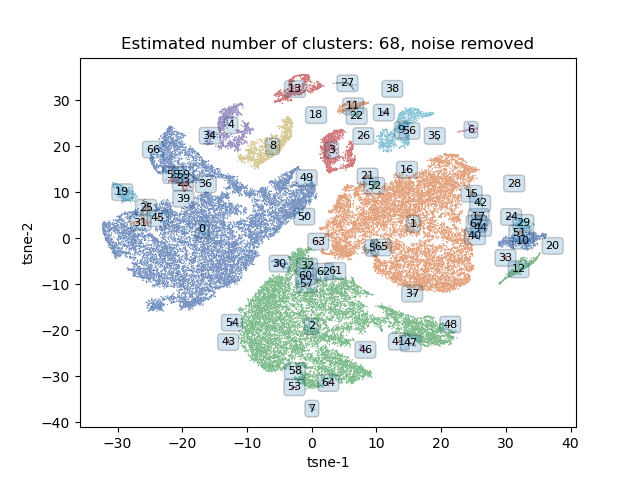

params for dbscan
minpts:  15
epsilon:  0.6143363229151764

running dbscan with epsilon: 0.6143363229151764  and minpts: 15
Estimated number of clusters: 49
Estimated number of noise points: 884


<IPython.core.display.Javascript object>


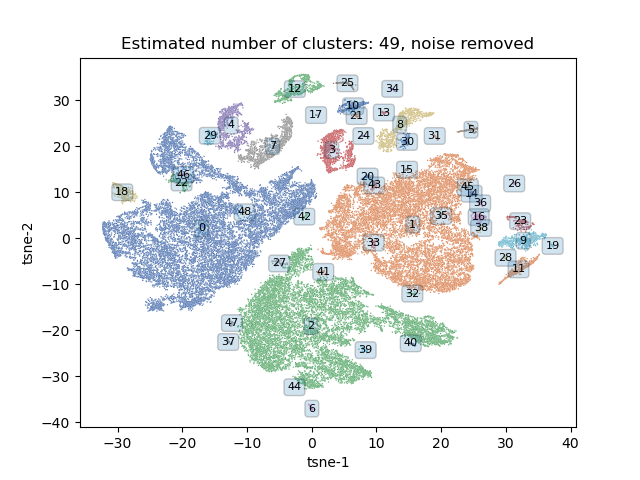

params for dbscan
minpts:  20
epsilon:  0.7058736140514038

running dbscan with epsilon: 0.7058736140514038  and minpts: 20
Estimated number of clusters: 41
Estimated number of noise points: 760


<IPython.core.display.Javascript object>


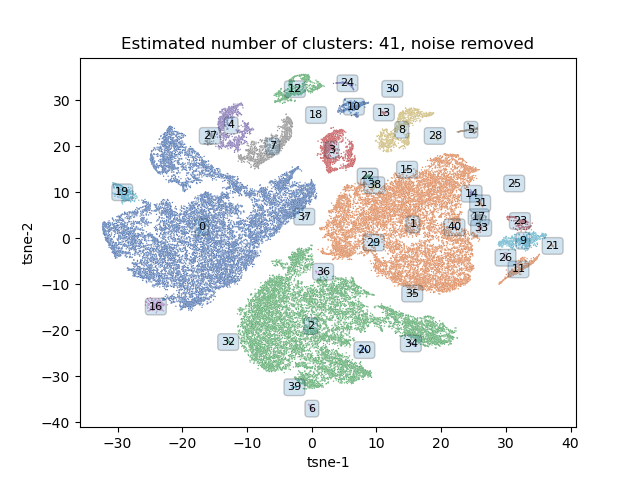

params for dbscan
minpts:  25
epsilon:  0.7888503375843723

running dbscan with epsilon: 0.7888503375843723  and minpts: 25
Estimated number of clusters: 36
Estimated number of noise points: 643


<IPython.core.display.Javascript object>


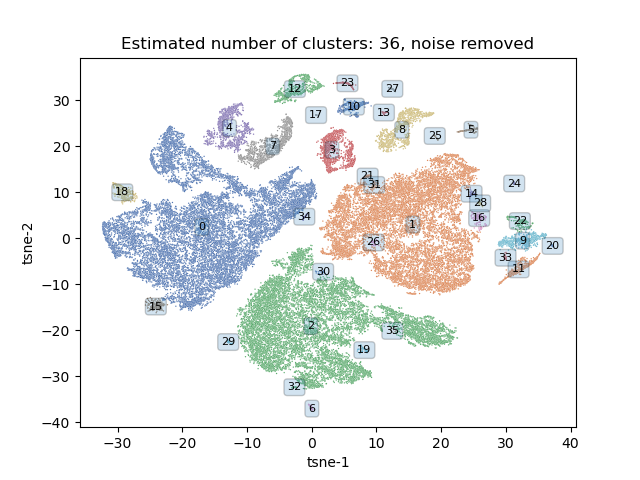

params for dbscan
minpts:  30
epsilon:  0.8648549559668066

running dbscan with epsilon: 0.8648549559668066  and minpts: 30
Estimated number of clusters: 31
Estimated number of noise points: 687


<IPython.core.display.Javascript object>


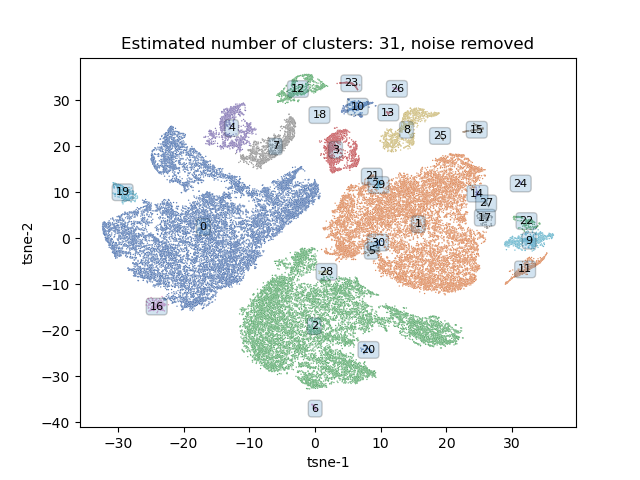

params for dbscan
minpts:  35
epsilon:  0.9342714289900461

running dbscan with epsilon: 0.9342714289900461  and minpts: 35
Estimated number of clusters: 26
Estimated number of noise points: 728


<IPython.core.display.Javascript object>


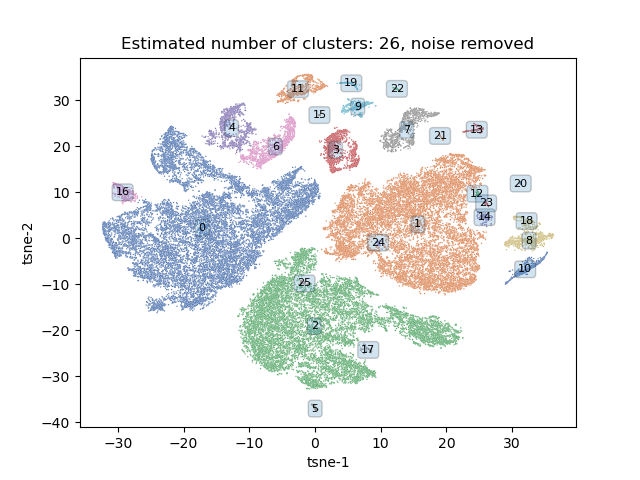

params for dbscan
minpts:  40
epsilon:  0.9975397976613091

running dbscan with epsilon: 0.9975397976613091  and minpts: 40
Estimated number of clusters: 24
Estimated number of noise points: 670


<IPython.core.display.Javascript object>


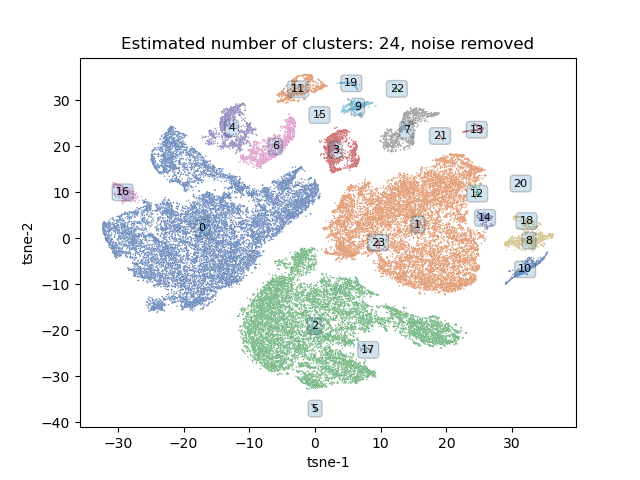

params for dbscan
minpts:  45
epsilon:  1.0542135071576464

running dbscan with epsilon: 1.0542135071576464  and minpts: 45
Estimated number of clusters: 23
Estimated number of noise points: 713


<IPython.core.display.Javascript object>


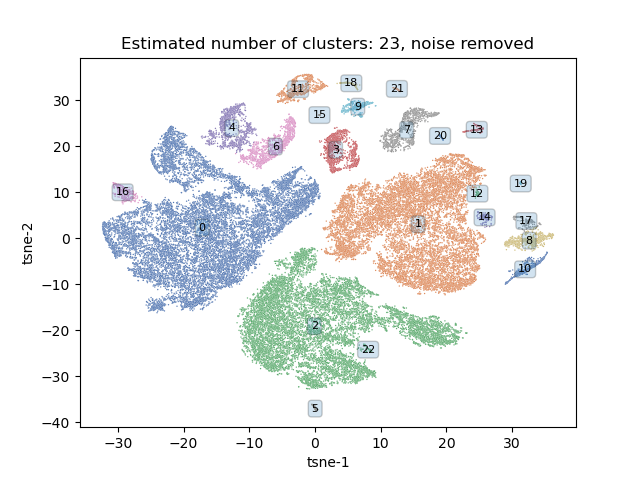

params for dbscan
minpts:  50
epsilon:  1.112447366828257

running dbscan with epsilon: 1.112447366828257  and minpts: 50
Estimated number of clusters: 22
Estimated number of noise points: 674


<IPython.core.display.Javascript object>


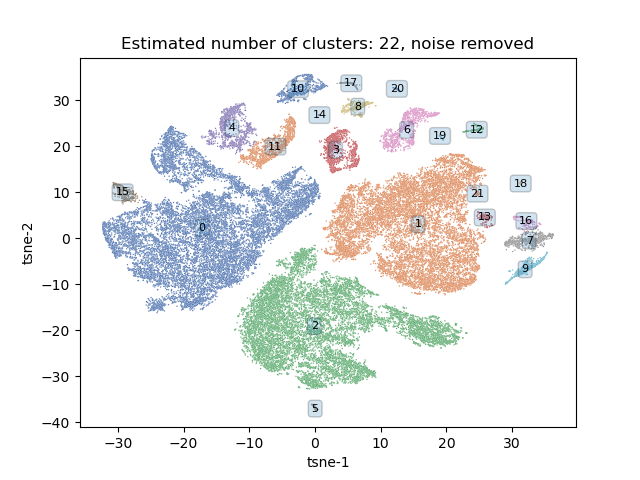

In [284]:
for m in range(10,55,5):
    epsilon, minpts, status_df = dp.compute_eps(minpts = m, eps_prc=90, arr= arr_tsne, status_df = status_df)
    labels,n_clusters, arr, status_df = dp.do_dbscan(epsilon = epsilon, minpts = minpts, arr = arr_tsne, status_df = status_df)

Pick case where minpts = 35

params for dbscan
minpts:  35
epsilon:  0.9342714289900461

running dbscan with epsilon: 0.9342714289900461  and minpts: 35
Estimated number of clusters: 26
Estimated number of noise points: 728


<IPython.core.display.Javascript object>


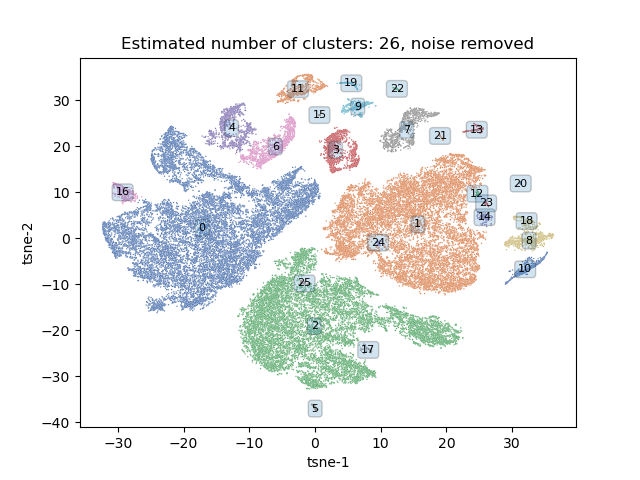

In [319]:
epsilon, minpts, status_df = dp.compute_eps(minpts = 35, eps_prc=90, arr= arr_tsne, status_df = status_df)
labels, n_clusters_, arr_df, status_df = dp.do_dbscan(epsilon = epsilon, minpts = minpts, arr = arr_tsne, status_df = status_df)

In [55]:
#numpy method to get cluster and pts per cluster
#c,p = np.unique(labels,return_counts=True)

View histogram showing number of pts per cluster

<IPython.core.display.Javascript object>


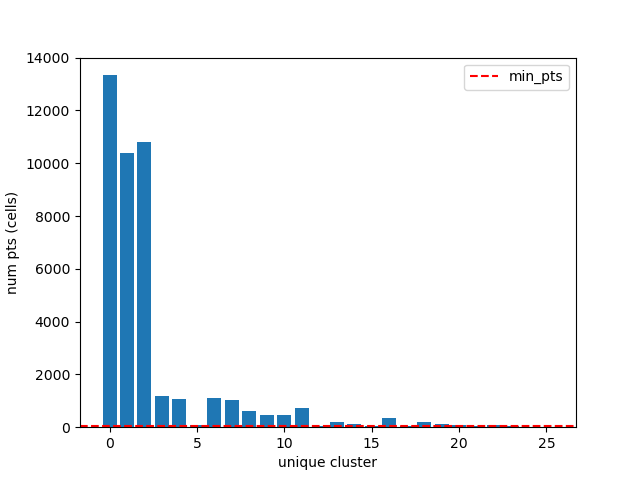

In [320]:
dp.histogram_pts_per_cluster(labels, minpts=minpts)

Reshuffle gene expression matrix, meta data using cluster labels

In [57]:
#df_pre_linkage, meta_data_df, unique_labels = dp.sort_by_cluster_label(df,meta_data_df,arr_df,labels)

In [58]:
#df_pre_linkage.head()

In [59]:
#meta_data_df

write df_pre_linkage and meta_data_df to file

In [60]:
len(np.arange(31))

31

In [61]:
#outfile_name = 'df_pre_linkage'
#df_pre_linkage.to_feather('/bigdata/isaac/'+outfile_name+'.feather')

#outfile_name = 'meta_data_df_pre_linkage'
#meta_data_df.to_json('/bigdata/isaac/'+outfile_name+'.json')

#meta_data_df = pd.read_json('/bigdata/isaac/meta_data_df_pre_linkage.json')

In [325]:
#try with normalized gene expr as input!
#outfile_name = 'df_pre_linkage_ls'
#df_pre_linkage.to_feather('/bigdata/isaac/'+outfile_name+'.feather')
#outfile_name = 'meta_data_df_pre_linkage_ls'
#meta_data_df.to_json('/bigdata/isaac/'+outfile_name+'.json')

#df_pre_linkage_ls = pd.read_feather('/bigdata/isaac/df_pre_linkage.feather')
#meta_data_df = pd.read_json('/bigdata/isaac/meta_data_df_pre_linkage.json')
#df_pre_linkage_ls, meta_data_df, unique_labels = dp.sort_by_cluster_label(df_ls,meta_data_df,arr_df,labels)

In [988]:
arr_df.shape

(42764, 3)

In [1007]:
arr_df.sort_values(by = 'labels')

tsne-1     tsne-2  labels
0     -23.218868  19.077335       0
14709  -8.881098  -3.160715       0
14710  -3.798371  14.041422       0
14711 -21.458900  -7.340003       0
14712  -3.079102   9.056833       0
...          ...        ...     ...
6930   -2.103757  -9.437999      25
12955  -1.481580  -9.597613      25
6770   -2.180107  -9.327950      25
2257   -1.199512 -10.114108      25
7683   -1.006134  -9.838076      25

[42764 rows x 3 columns]

In [987]:
df_ls.shape

(744, 43492)

In [363]:
df_pre_linkage_ls, meta_data_df, unique_labels = dp.sort_by_cluster_label(df_ls,meta_data_df,arr_df,labels)

In [364]:
df_pre_linkage_ls.shape

(42764, 744)

In [365]:
meta_data_df.shape

(28, 42764)

In [994]:
df_pre_linkage_ls.index

Index(['AAACCCAAGAGCATAT-1_10X51_2', 'TATTTCGGTTCATCGA-1_10X51_3',
       'TATTTCGTCCACCTGT-1_10X51_3', 'TCAAGACTCCTAAGTG-1_10X51_3',
       'TCAAGCATCGTCTAAG-1_10X51_3', 'TCAAGTGCAGAGGAAA-1_10X51_3',
       'TCAAGTGTCCGGACGT-1_10X51_3', 'TCAATCTAGGCGTTGA-1_10X51_3',
       'ATACTTCCAATCAAGA-1_10X36_1', 'TCAATTCAGTATAGGT-1_10X51_3',
       ...
       'TGATCAGCAAACAGGC-1_10X35_2', 'ACTTATCGTTGTAGCT-1_10X37_1',
       'TGGGTTATCGATACTG-1_10X51_4', 'TACTGCCAGCCTCAGC-1_10X52_2',
       'GGGTGTCGTGGGATTG-1_10X51_4', 'AGACCATGTTGAATCC-1_10X52_1',
       'TTGTTGTCAAGTGGTG-1_10X52_2', 'ACAGAAATCTCGTCAC-1_10X52_1',
       'GTGGAAGGTGGGTCAA-1_10X51_2', 'CGAATTGAGCCTGGAA-1_10X52_1'],
      dtype='object', length=42764)

## Sorting <a name="cluster_sort"></a>

### Inter Cluster sorting <a name="inter_cluster_sort"></a>

Inter cluster Order determined as follows:
1) compute mean per gene per cluster(n_genes x n_clusters)
2) PCA reduce genes to n_components (10)
3) Compute distance matrix on PCA reduced array using 'correlation' as distance metric
4) Compute linkage on distance matrix using 'ward' linkage alg to determine cluster order

In [366]:
linkage_alg = 'ward'
dist_metric = 'euclidean'

<IPython.core.display.Javascript object>


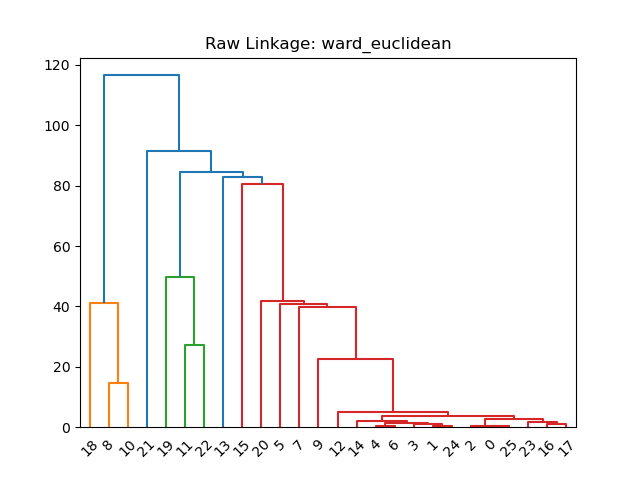

[18  8 10 21 19 11 22 15  5 12 14  3  1 24  4  6 25  0  2 17 16 23  9  7
 20 13]


<IPython.core.display.Javascript object>


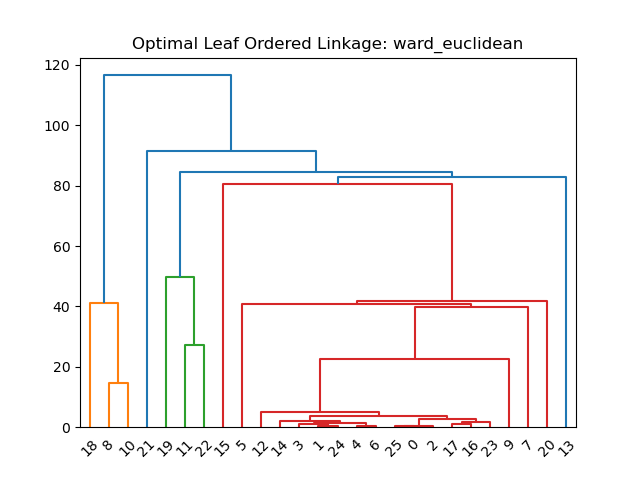

In [371]:
df_post_linkage, meta_data_df, linkage_cluster_order, Z_ordered, mpg_pca, linkage_cluster_order_po = dp.inter_cluster_sort(df_pre_linkage_ls,
                                                 meta_data_df, 
                                                 unique_labels,
                                                 n_components = 10, 
                                                 linkage_alg = linkage_alg,
                                                 dist_metric = dist_metric)

In [372]:
linkage_cluster_order_po

[18,
 8,
 10,
 21,
 19,
 11,
 22,
 13,
 15,
 20,
 5,
 7,
 9,
 12,
 14,
 4,
 6,
 3,
 1,
 24,
 2,
 0,
 25,
 23,
 16,
 17]

In [373]:
linkage_cluster_order

array([18,  8, 10, 21, 19, 11, 22, 15,  5, 12, 14,  3,  1, 24,  4,  6, 25,
        0,  2, 17, 16, 23,  9,  7, 20, 13], dtype=int32)

In [374]:
df_post_linkage.head()

GCTTTCGTCACACGAT-1_10X51_3  TTGGGTAGTGTTCCTC-1_10X36_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                    0.387706   
Hba-a1                   -0.035357                   -0.035357   

        GGGCCATCACTAACCA-1_10X51_1  AGGACGACACAACGTT-1_10X37_1  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        ATCACAGGTCATCTAG-1_10X35_1  CCCTGATCAACGTTAC-1_10X35_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        GTAGCTACATGTGCTA-1_10X37_1  GATTCGAAGACTCTTG-1_10X51_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        CTACGGGGTACTGACT-1_10X52_2  GGGTGTCGTTGTGGAG-1_10X37_1  ...  \
gene                                                            ...   
Hbb-bs                   -0.063512                   -0.063512  ...   
Oxt                      -0.098764                   -0.098764  ...   
Avp                       1.829205                   -0.182275  ...   
Plp1                     -0.406017                    0.387706  ...   
Hba-a1                   -0.035357                   -0.035357  ...   

        GCCATTCTCCATCTGC-1_10X36_1  ATTCACTGTTGACTAC-1_10X52_4  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                      6.125383                    1.181428   
Hba-a1                   -0.035357                   -0.035357   

        CATGGATCACTGAGGA-1_10X38_1  CGCGTGATCCGCACGA-1_10X36_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        CATTCATAGGCACCAA-1_10X52_2  CTCGAGGAGGTTGACG-1_10X37_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        TCATATCCAACAGAGC-1_10X52_3  GTAATGCAGGTAGTCG-1_10X35_1  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp  

In [375]:
meta_data_df.tail()

GCTTTCGTCACACGAT-1_10X51_3 TTGGGTAGTGTTCCTC-1_10X36_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               22.0                       12.1   
lengthbp_seqlib                             487.0                      486.0   
Sample_Index                                   B2                         A9   
cluster_label                                  18                         18   

                       GGGCCATCACTAACCA-1_10X51_1 AGGACGACACAACGTT-1_10X37_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               19.2                       15.9   
lengthbp_seqlib                             478.0                      440.0   
Sample_Index                                   G1                         E9   
cluster_label                                  18                         18   

                       ATCACAGGTCATCTAG-1_10X35_1 CCCTGATCAACGTTAC-1_10X35_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               13.6                       17.6   
lengthbp_seqlib                             416.0                      461.0   
Sample_Index                                   D9                         G8   
cluster_label                                  18                         18   

                       GTAGCTACATGTGCTA-1_10X37_1 GATTCGAAGACTCTTG-1_10X51_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.9                       22.2   
lengthbp_seqlib                             440.0                      474.0   
Sample_Index                                   E9                         A2   
cluster_label                                  18                         18   

                       CTACGGGGTACTGACT-1_10X52_2 GGGTGTCGTTGTGGAG-1_10X37_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               17.5                       15.9   
lengthbp_seqlib                             440.0                      440.0   
Sample_Index                                  E12                         E9   
cluster_label                                  18                         18   

                        ... GCCATTCTCCATCTGC-1_10X36_1  \
LIbConstructionComment  ...                              
ngperul_seqlib          ...                       11.4   
lengthbp_seqlib         ...                      476.0   
Sample_Index            ...                         H8   
cluster_label           ...                         13   

                       ATTCACTGTTGACTAC-1_10X52_4 CATGGATCACTGAGGA-1_10X38_1  \
LIbConstructionComment                                                         
ngperul_seqlib                 8.94 (second prep)                       15.0   
lengthbp_seqlib                             535.0                      420.0   
Sample_Index                                  G12                         B9   
cluster_label                                  13                         13   

                       CGCGTGATCCGCACGA-1_10X36_2 CATTCATAGGCACCAA-1_10X52_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               12.1                       17.5   
lengthbp_seqlib                             486.0                      440.0   
Sample_Index                                   A9                        E12   
cluster_label                                  13                         13   

                       CTCGAGGAGGTTGACG-1_10X37_2 TCATATCCAACAGAGC-1_10X52_3  \
LIbConstructionComment                                                         
ngperul_seqlib                               16.0          20.4(second prep)   
lengthbp_seqlib                             460.0                  

verify cluster labels in metadata match linkage_cluster_order

In [376]:
l, idx = np.unique(np.array(meta_data_df.loc['cluster_label',:]), return_index=True)
l_ordered = l[np.argsort(idx)]
l_ordered

array([18, 8, 10, 21, 19, 11, 22, 15, 5, 12, 14, 3, 1, 24, 4, 6, 25, 0, 2,
       17, 16, 23, 9, 7, 20, 13], dtype=object)

In [377]:
df_post_linkage.shape

(744, 42764)

Compare Correlation matrix of mean per gene per cluster before/after inter cluster sort

In [378]:
mpg_pca_df = pd.DataFrame(data = mpg_pca)

<IPython.core.display.Javascript object>


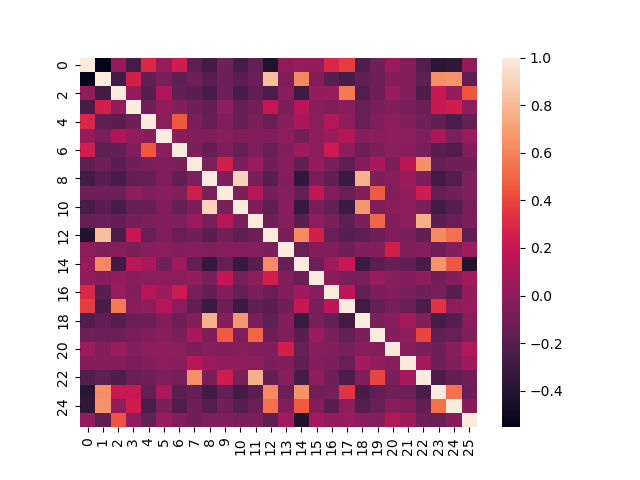

In [379]:
plt.figure()
ax = sns.heatmap(mpg_pca_df.corr(method='pearson'))
plt.show()

After inter cluster sort (use columns = linkage_cluster_order for optimized leaf order, columns = linkage_cluster_order_po for pre-optimized leaf order)

In [384]:
mpg_pca_pl_df = mpg_pca_df.reindex(columns = linkage_cluster_order)

<IPython.core.display.Javascript object>


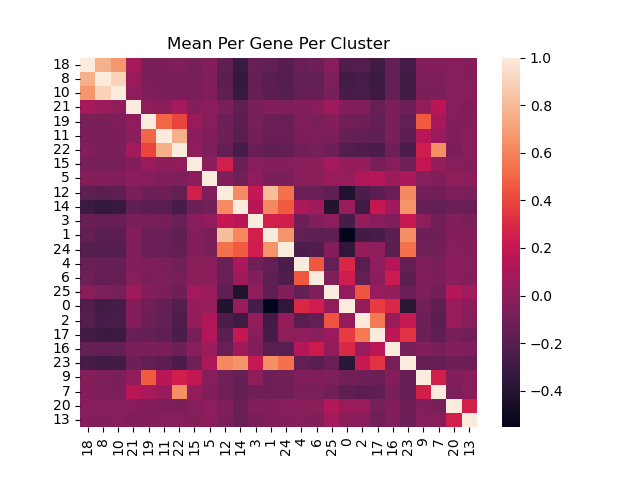

In [385]:
plt.figure()
ax = sns.heatmap(mpg_pca_pl_df.corr(method='pearson'), yticklabels=True, xticklabels=True)
plt.title('Mean Per Gene Per Cluster')
#plt.savefig('mpg_pca_corr_post_linkage')
plt.show()

<IPython.core.display.Javascript object>


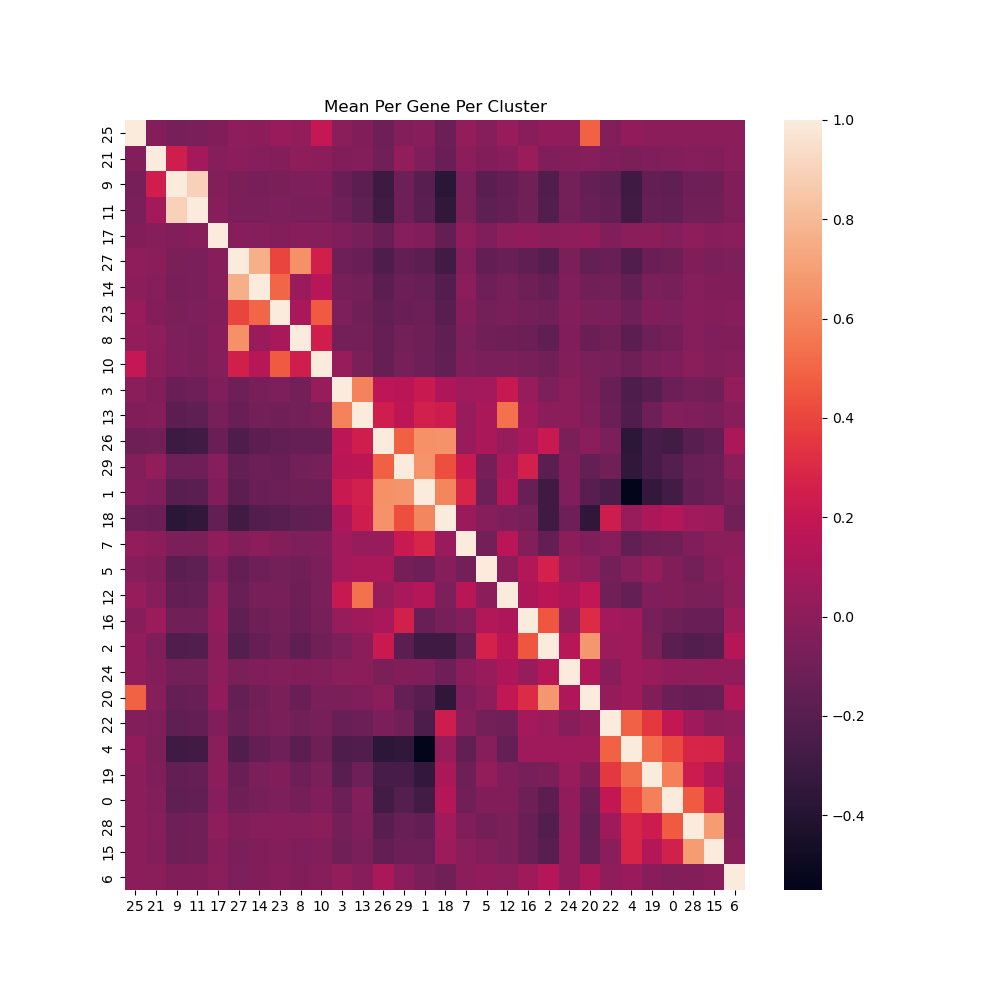

In [76]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(mpg_pca_pl_df.corr(method='pearson'), yticklabels=True, xticklabels=True)
plt.title('Mean Per Gene Per Cluster')
#plt.savefig('mpg_pca_corr_post_linkage')
plt.show()

In [386]:
df_pre_linkage_ls.head()

gene                          Hbb-bs       Oxt       Avp      Plp1    Hba-a1  \
AAACCCAAGAGCATAT-1_10X51_2 -0.063512 -0.098764 -0.182275 -0.406017 -0.035357   
TATTTCGGTTCATCGA-1_10X51_3 -0.063512 -0.098764 -0.182275 -0.406017 -0.035357   
TATTTCGTCCACCTGT-1_10X51_3 -0.063512 -0.098764 -0.182275 -0.406017 -0.035357   
TCAAGACTCCTAAGTG-1_10X51_3 -0.063512 -0.098764 -0.182275  0.387706 -0.035357   
TCAAGCATCGTCTAAG-1_10X51_3 -0.063512 -0.098764 -0.182275 -0.406017 -0.035357   

gene                           Ptgds    Hba-a2    Hbb-bt     Acta2     Apoe  \
AAACCCAAGAGCATAT-1_10X51_2  0.990841 -0.047993 -0.028598 -0.076475 -0.41404   
TATTTCGGTTCATCGA-1_10X51_3 -0.241152 -0.047993 -0.028598 -0.076475 -0.41404   
TATTTCGTCCACCTGT-1_10X51_3 -0.241152 -0.047993 -0.028598 -0.076475 -0.41404   
TCAAGACTCCTAAGTG-1_10X51_3 -0.241152 -0.047993 -0.028598 -0.076475 -0.41404   
TCAAGCATCGTCTAAG-1_10X51_3 -0.241152 -0.047993 -0.028598 -0.076475 -0.41404   

gene                        ...   Ccdc153   Fam64a     Hpgds     Asic4  \
AAACCCAAGAGCATAT-1_10X51_2  ... -0.162285 -0.03567 -0.312151 -0.176552   
TATTTCGGTTCATCGA-1_10X51_3  ... -0.162285 -0.03567 -0.312151 -0.176552   
TATTTCGTCCACCTGT-1_10X51_3  ... -0.162285 -0.03567  2.769519 -0.176552   
TCAAGACTCCTAAGTG-1_10X51_3  ... -0.162285 -0.03567  2.769519 -0.176552   
TCAAGCATCGTCTAAG-1_10X51_3  ... -0.162285 -0.03567 -0.312151 -0.176552   

gene                          Fgfbp1   Rps27rt   Prox1os    Tmem47      Tns4  \
AAACCCAAGAGCATAT-1_10X51_2 -0.030887 -0.721071 -0.226503 -0.697193 -0.022524   
TATTTCGGTTCATCGA-1_10X51_3 -0.030887 -0.721071 -0.226503  0.718921 -0.022524   
TATTTCGTCCACCTGT-1_10X51_3 -0.030887 -0.721071 -0.226503 -0.697193 -0.022524   
TCAAGACTCCTAAGTG-1_10X51_3 -0.030887  0.767217 -0.226503 -0.697193 -0.022524   
TCAAGCATCGTCTAAG-1_10X51_3 -0.030887 -0.721071 -0.226503  2.590921 -0.022524   

gene                           Dusp2  
AAACCCAAGAGCATAT-1_10X51_2 -0.138418  
TATTTCGGTTCATCGA-1_10X51_3 -0.138418  
TATTTCGTCCACCTGT-1_10X51_3 -0.138418  
TCAAGACTCCTAAGTG-1_10X51_3 -0.138418  
TCAAGCATCGTCTAAG-1_10X51_3 -0.138418  

[5 rows x 744 columns]

In [387]:
df_post_linkage.head()

GCTTTCGTCACACGAT-1_10X51_3  TTGGGTAGTGTTCCTC-1_10X36_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                    0.387706   
Hba-a1                   -0.035357                   -0.035357   

        GGGCCATCACTAACCA-1_10X51_1  AGGACGACACAACGTT-1_10X37_1  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        ATCACAGGTCATCTAG-1_10X35_1  CCCTGATCAACGTTAC-1_10X35_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        GTAGCTACATGTGCTA-1_10X37_1  GATTCGAAGACTCTTG-1_10X51_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        CTACGGGGTACTGACT-1_10X52_2  GGGTGTCGTTGTGGAG-1_10X37_1  ...  \
gene                                                            ...   
Hbb-bs                   -0.063512                   -0.063512  ...   
Oxt                      -0.098764                   -0.098764  ...   
Avp                       1.829205                   -0.182275  ...   
Plp1                     -0.406017                    0.387706  ...   
Hba-a1                   -0.035357                   -0.035357  ...   

        GCCATTCTCCATCTGC-1_10X36_1  ATTCACTGTTGACTAC-1_10X52_4  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                      6.125383                    1.181428   
Hba-a1                   -0.035357                   -0.035357   

        CATGGATCACTGAGGA-1_10X38_1  CGCGTGATCCGCACGA-1_10X36_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        CATTCATAGGCACCAA-1_10X52_2  CTCGAGGAGGTTGACG-1_10X37_2  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp                      -0.182275                   -0.182275   
Plp1                     -0.406017                   -0.406017   
Hba-a1                   -0.035357                   -0.035357   

        TCATATCCAACAGAGC-1_10X52_3  GTAATGCAGGTAGTCG-1_10X35_1  \
gene                                                             
Hbb-bs                   -0.063512                   -0.063512   
Oxt                      -0.098764                   -0.098764   
Avp  

Use linkage order determined from inter cluster sorting with _ls (log and standerdized) input to reshuffle df, and use this going forward

In [388]:
df_s = df.reindex(columns = df_post_linkage.columns)

In [389]:
df_s

GCTTTCGTCACACGAT-1_10X51_3  TTGGGTAGTGTTCCTC-1_10X36_2  \
gene                                                              
Hbb-bs                            0                           0   
Oxt                               0                           0   
Avp                               0                           0   
Plp1                              0                           1   
Hba-a1                            0                           0   
...                             ...                         ...   
Rps27rt                           1                           1   
Prox1os                           0                           0   
Tmem47                            0                           0   
Tns4                              0                           0   
Dusp2                             0                           0   

         GGGCCATCACTAACCA-1_10X51_1  AGGACGACACAACGTT-1_10X37_1  \
gene                                                              
Hbb-bs                            0                           0   
Oxt                               0                           0   
Avp                               0                           0   
Plp1                              0                           0   
Hba-a1                            0                           0   
...                             ...                         ...   
Rps27rt                           0                           1   
Prox1os                           0                           0   
Tmem47                            1                           0   
Tns4                              0                           0   
Dusp2                             0                           0   

         ATCACAGGTCATCTAG-1_10X35_1  CCCTGATCAACGTTAC-1_10X35_2  \
gene                                                              
Hbb-bs                            0                           0   
Oxt                               0                           0   
Avp                               0                           0   
Plp1                              0                           0   
Hba-a1                            0                           0   
...                             ...                         ...   
Rps27rt                           0                           1   
Prox1os                           0                           0   
Tmem47                            0                           0   
Tns4                              0                           0   
Dusp2                             0                           0   

         GTAGCTACATGTGCTA-1_10X37_1  GATTCGAAGACTCTTG-1_10X51_2  \
gene                                                              
Hbb-bs                            0                           0   
Oxt                               0                           0   
Avp                               0                           0   
Plp1                              0                           0   
Hba-a1                            0                           0   
...                             ...                         ...   
Rps27rt                           0                           0   
Prox1os                           0                           0   
Tmem47                            1                           0   
Tns4                              0                           0   
Dusp2                             0                           0   

         CTACGGGGTACTGACT-1_10X52_2  GGGTGTCGTTGTGGAG-1_10X37_1  ...  \
gene                                                             ...   
Hbb-bs                            0                           0  ...   
Oxt                               0                           0  ...   
Avp                               1                           0  ...   
Plp1                              0                           1  ...   
Hba-a1                            0                           0  ...   
...              

### Intra Cluster sorting <a name="intra_cluster_sort"></a>

Intra cluster sorting  - For every unique cluster, perform 1D tsne, then use ascending TSNE values reshuffle within cluster.
Note - after rerunning with harmony and n_clusters = 26, changed perplexity to 15 from 30 (was getting perplexity must be less than n_samples error)

In [394]:
df_post_linkage_intra_sorted, meta_data_df, cluster_indices = dp.intra_cluster_sort(df_s, meta_data_df, linkage_cluster_order)

In [397]:
df_post_linkage_intra_sorted.head()

CTTCTCTTCACAATGC-1_10X37_1  AATGGCTGTTGGCTAT-1_10X38_1  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           0   
Hba-a1                           0                           1   

        ATGACCACACATTGTG-1_10X35_2  CTGCATCCAAATGGTA-1_10X52_3  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           1   
Hba-a1                           0                           0   

        ACCAACACAGCTCGGT-1_10X37_1  CGAGAAGGTTCAGCGC-1_10X52_3  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           0   
Hba-a1                           0                           0   

        TACTGCCGTCTCCCTA-1_10X38_1  TCATTTGAGCTGCGAA-1_10X37_1  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           0   
Hba-a1                           0                           0   

        TTCGATTTCCATCTCG-1_10X38_1  GGTAGAGAGAGGATGA-1_10X37_2  ...  \
gene                                                            ...   
Hbb-bs                           1                           0  ...   
Oxt                              0                           0  ...   
Avp                              1                           0  ...   
Plp1                             0                           0  ...   
Hba-a1                           0                           0  ...   

        GTTGAACGTCCTATAG-1_10X35_2  ATGCGATAGGTTAAAC-1_10X35_1  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             1                           0   
Hba-a1                           0                           0   

        GTCCACTGTTGCTCAA-1_10X38_1  CGTAAGTGTAGATCGG-1_10X37_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           2   
Hba-a1                           0                           0   

        TGACGCGTCCTATTTG-1_10X51_2  GTCAAACGTCAACCAT-1_10X52_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp                              0                           0   
Plp1                             0                           0   
Hba-a1                           0                           0   

        TGTCAGACACACGGTC-1_10X52_2  GATCCCTTCGTAGCTA-1_10X35_2  \
gene                                                             
Hbb-bs                           0                           0   
Oxt                              0                           0   
Avp  

In [398]:
meta_data_df.tail()

CTTCTCTTCACAATGC-1_10X37_1 AATGGCTGTTGGCTAT-1_10X38_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.9                       15.0   
lengthbp_seqlib                             440.0                      420.0   
Sample_Index                                   E9                         B9   
cluster_label                                  18                         18   

                       ATGACCACACATTGTG-1_10X35_2 CTGCATCCAAATGGTA-1_10X52_3  \
LIbConstructionComment                                                         
ngperul_seqlib                               17.6          20.4(second prep)   
lengthbp_seqlib                             461.0                      507.0   
Sample_Index                                   G8                        F12   
cluster_label                                  18                         18   

                       ACCAACACAGCTCGGT-1_10X37_1 CGAGAAGGTTCAGCGC-1_10X52_3  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.9          20.4(second prep)   
lengthbp_seqlib                             440.0                      507.0   
Sample_Index                                   E9                        F12   
cluster_label                                  18                         18   

                       TACTGCCGTCTCCCTA-1_10X38_1 TCATTTGAGCTGCGAA-1_10X37_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.0                       15.9   
lengthbp_seqlib                             420.0                      440.0   
Sample_Index                                   B9                         E9   
cluster_label                                  18                         18   

                       TTCGATTTCCATCTCG-1_10X38_1 GGTAGAGAGAGGATGA-1_10X37_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.0                       16.0   
lengthbp_seqlib                             420.0                      460.0   
Sample_Index                                   B9                         F9   
cluster_label                                  18                         18   

                        ... GTTGAACGTCCTATAG-1_10X35_2  \
LIbConstructionComment  ...                              
ngperul_seqlib          ...                       17.6   
lengthbp_seqlib         ...                      461.0   
Sample_Index            ...                         G8   
cluster_label           ...                         13   

                       ATGCGATAGGTTAAAC-1_10X35_1 GTCCACTGTTGCTCAA-1_10X38_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               13.6                       15.0   
lengthbp_seqlib                             416.0                      420.0   
Sample_Index                                   D9                         B9   
cluster_label                                  13                         13   

                       CGTAAGTGTAGATCGG-1_10X37_2 TGACGCGTCCTATTTG-1_10X51_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               16.0                       22.2   
lengthbp_seqlib                             460.0                      474.0   
Sample_Index                                   F9                         A2   
cluster_label                                  13                         13   

                       GTCAAACGTCAACCAT-1_10X52_2 TGTCAGACACACGGTC-1_10X52_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               17.5                       17.5   
lengthbp_seqlib                             440.0                  

Verify cluster_label in meta data are still in same order (inter cluster order remains the same)

In [399]:
l, idx = np.unique(np.array(meta_data_df.loc['cluster_label',:]), return_index=True)
l_ordered = l[np.argsort(idx)]
l_ordered

array([18, 8, 10, 21, 19, 11, 22, 15, 5, 12, 14, 3, 1, 24, 4, 6, 25, 0, 2,
       17, 16, 23, 9, 7, 20, 13], dtype=object)

In [400]:
df_post_linkage_intra_sorted.shape

(744, 42764)

## Marker Genes<a name="markergenes"></a>

In [401]:
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [402]:
for c, idx in zip(linkage_cluster_order,cluster_indices):
    print (f'cluster {c}, num_cells {len(idx)}')

cluster 18, num_cells 198
cluster 8, num_cells 608
cluster 10, num_cells 473
cluster 21, num_cells 55
cluster 19, num_cells 139
cluster 11, num_cells 732
cluster 22, num_cells 90
cluster 15, num_cells 63
cluster 5, num_cells 99
cluster 12, num_cells 48
cluster 14, num_cells 122
cluster 3, num_cells 1183
cluster 1, num_cells 10398
cluster 24, num_cells 25
cluster 4, num_cells 1065
cluster 6, num_cells 1124
cluster 25, num_cells 20
cluster 0, num_cells 13336
cluster 2, num_cells 10787
cluster 17, num_cells 48
cluster 16, num_cells 345
cluster 23, num_cells 37
cluster 9, num_cells 452
cluster 7, num_cells 1038
cluster 20, num_cells 76
cluster 13, num_cells 203


### Compute Markers <a name="compute_marker_genes"></a>

In [403]:
marker_genes_sorted, pos, ind, ind_s, mgs = dp.compute_marker_genes(df_post_linkage_intra_sorted,
                                                meta_data_df,
                                                cluster_indices,
                                                linkage_cluster_order,
                                                n_markers=5)

/home/isaac/analysis/scRNA-seq/dimorph_processing.py:662: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0_ind_arr = xi0_ind_arr[:n_markers,:]
/home/isaac/analysis/scRNA-seq/dimorph_processing.py:667: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0p5_ind_arr = xi0p5_ind_arr[:n_markers,:]
/home/isaac/analysis/scRNA-seq/dimorph_processing.py:672: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi1_ind_arr = xi1_ind_arr[:n_markers,:]


[ 0  0  0  0  0  0  0  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  3  3
  3  3  3  3  4  4  4  4  4  4  5  5  5  5  5  5  5  5  6  6  3  6  6  5
  7  7  7  7  7  7  8  8  8  8  8  8 21  3 21  8  9  9  9  9 10 11 10 11
 11  8 11 11 22 11 10 13 13 11 13 13 21 14 14 14 14 14 14 15 15 15 15  3
 15 15  1 16 21 19  9 19 19 21 17 20 10 20 20 14 14 18  8 20 21 19 19 19
 19 19 19 19 19 19 20 20 20 20 20 20 20 11 22 22 22  4  4 22 22 23 23 23
 23  3 23  6 23 24 24 24 24 24 25 25 25 25 25 25 25 25 25]
[  0   1   2   3   4   5   6  19  18  17  16  15  14  10  12  11  20   9
   8   7  98  21  13 145  61  44  27  95  22  23  24  26  25  28  29  30
  31  32  33 137 138  47  39  38  41  34  35  40  36  37  42 147  43  46
  45  52  49  48  51  53  50  58  57  56  63  55  54 114  73  59 102  66
  67  65  64  68 108  70  78 133  81  77  72  71  74  75  69  82  80  79
  83  86  87  88  89  90 111 112  85  97  96  93  92  91  94  99 106 113
 119 121 122 123 124 125 120 117 118 101 104 103 115 132 131 130 

In [404]:
list(marker_genes_sorted)

['Tagln',
 'Acta2',
 'Myh11',
 'Pln',
 'Gkn3',
 'Tpm2',
 'Crip1',
 'Ly6a',
 'Slco1a4',
 'Cldn5',
 'Ctla2a',
 'Slc38a5',
 'Gm9946',
 'Vtn',
 'Higd1b',
 'Atp13a5',
 'Flt1',
 'Ifitm1',
 'Kcnj8',
 'Abcc9',
 'Zic1',
 'Ly6c1',
 'Cd93',
 'Mlc1',
 'Cd24a',
 'Ptgds',
 'Stoml3',
 'Sncg',
 'Tmem212',
 '3300002A11Rik',
 'Sntn',
 'Calml4',
 'Gm10714',
 'Enpp6',
 'Cnksr3',
 'Folr2',
 'Gpr17',
 'Bcas1',
 'Bfsp2',
 'Neu4',
 'Olig2',
 'Trf',
 'Mal',
 'Aspa',
 'Plp1',
 'Mog',
 'Opalin',
 'Mobp',
 'Ermn',
 'Gjb1',
 'Itih3',
 'Agt',
 'Slc7a10',
 'Gjb6',
 'Il33',
 'Aurkb',
 'Cdk1',
 'Pbk',
 'Fam64a',
 'Lockd',
 'Top2a',
 'Pou3f2',
 'Pla2r1',
 'Ebf3',
 'C1ql2',
 'Avp',
 'Oxt',
 'Otp',
 'Sim1',
 'Pdyn',
 'C730034F03Rik',
 'Crym',
 'Nptx1',
 'Bhlhe22',
 'Lpl',
 'Col6a1',
 'Cartpt',
 'Nfix',
 'Nfib',
 'Zbtb18',
 'Prdm8',
 'Cbln2',
 'Cyp26b1',
 'Slc17a7',
 'Neurod6',
 'Pou3f1',
 'Neurod2',
 'P2rx4',
 'Ppp1r17',
 'Tac1',
 'Igfbp5',
 'Cplx3',
 'Hapln1',
 'Egfr',
 'Kit',
 'Reln',
 'Gad2',
 'Gad1',
 'Ndnf',
 'Cnr1'

In [646]:
#use list of indices corresponding to column with max value of marker array
#to get sorted version
indy = np.sort(ind)

#get gene indices
g = []
for i in np.arange(0,len(np.unique(ind))):
    #print(i)
    x = ind_s[np.where(indy==i)]
    g.append(x)
    
#use full marker gene list to convert list of indices to gene names
tg = []
for i in g:
    gene = [mgs[x] for x in i]
    #print(gene)
    tg.append(gene)
    
#formatting fix #1 - add newline char after each gene so labels are stacked vertically
tgf = []
for i,x in enumerate(tg):
    a = '\n '.join(tg[i])
    tgf.append(a)

#formatting fix#2 - add space before 1st char in for each gene string list to fix alignment issue 
tgfs = []
for i in tgf:
    x = ' ' + i
    tgfs.append(x)

In [427]:
linkage_cluster_order

array([18,  8, 10, 21, 19, 11, 22, 15,  5, 12, 14,  3,  1, 24,  4,  6, 25,
        0,  2, 17, 16, 23,  9,  7, 20, 13], dtype=int32)

In [428]:
marker_genes_sorted

['Tagln',
 'Acta2',
 'Myh11',
 'Pln',
 'Gkn3',
 'Tpm2',
 'Crip1',
 'Ly6a',
 'Slco1a4',
 'Cldn5',
 'Ctla2a',
 'Slc38a5',
 'Gm9946',
 'Vtn',
 'Higd1b',
 'Atp13a5',
 'Flt1',
 'Ifitm1',
 'Kcnj8',
 'Abcc9',
 'Zic1',
 'Ly6c1',
 'Cd93',
 'Mlc1',
 'Cd24a',
 'Ptgds',
 'Stoml3',
 'Sncg',
 'Tmem212',
 '3300002A11Rik',
 'Sntn',
 'Calml4',
 'Gm10714',
 'Enpp6',
 'Cnksr3',
 'Folr2',
 'Gpr17',
 'Bcas1',
 'Bfsp2',
 'Neu4',
 'Olig2',
 'Trf',
 'Mal',
 'Aspa',
 'Plp1',
 'Mog',
 'Opalin',
 'Mobp',
 'Ermn',
 'Gjb1',
 'Itih3',
 'Agt',
 'Slc7a10',
 'Gjb6',
 'Il33',
 'Aurkb',
 'Cdk1',
 'Pbk',
 'Fam64a',
 'Lockd',
 'Top2a',
 'Pou3f2',
 'Pla2r1',
 'Ebf3',
 'C1ql2',
 'Avp',
 'Oxt',
 'Otp',
 'Sim1',
 'Pdyn',
 'C730034F03Rik',
 'Crym',
 'Nptx1',
 'Bhlhe22',
 'Lpl',
 'Col6a1',
 'Cartpt',
 'Nfix',
 'Nfib',
 'Zbtb18',
 'Prdm8',
 'Cbln2',
 'Cyp26b1',
 'Slc17a7',
 'Neurod6',
 'Pou3f1',
 'Neurod2',
 'P2rx4',
 'Ppp1r17',
 'Tac1',
 'Igfbp5',
 'Cplx3',
 'Hapln1',
 'Egfr',
 'Kit',
 'Reln',
 'Gad2',
 'Gad1',
 'Ndnf',
 'Cnr1'

In [429]:
len(cluster_indices[0])

198

In [430]:
df_marker = df_post_linkage_intra_sorted.loc[marker_genes_sorted,:]

In [431]:
df_marker.shape

(163, 42764)

In [432]:
df_marker.head()

CTTCTCTTCACAATGC-1_10X37_1  AATGGCTGTTGGCTAT-1_10X38_1  \
gene                                                            
Tagln                          20                           8   
Acta2                          36                          19   
Myh11                          31                           8   
Pln                             2                           1   
Gkn3                           28                           1   

       ATGACCACACATTGTG-1_10X35_2  CTGCATCCAAATGGTA-1_10X52_3  \
gene                                                            
Tagln                           7                          24   
Acta2                          14                          27   
Myh11                           5                           2   
Pln                             6                           0   
Gkn3                           10                          13   

       ACCAACACAGCTCGGT-1_10X37_1  CGAGAAGGTTCAGCGC-1_10X52_3  \
gene                                                            
Tagln                          20                          24   
Acta2                          64                          45   
Myh11                           7                          10   
Pln                            12                           2   
Gkn3                            5                           0   

       TACTGCCGTCTCCCTA-1_10X38_1  TCATTTGAGCTGCGAA-1_10X37_1  \
gene                                                            
Tagln                          23                          18   
Acta2                          57                          48   
Myh11                           5                           4   
Pln                             2                           3   
Gkn3                           27                          23   

       TTCGATTTCCATCTCG-1_10X38_1  GGTAGAGAGAGGATGA-1_10X37_2  ...  \
gene                                                           ...   
Tagln                          19                          43  ...   
Acta2                          41                          68  ...   
Myh11                          18                          22  ...   
Pln                             5                           3  ...   
Gkn3                           14                          14  ...   

       GTTGAACGTCCTATAG-1_10X35_2  ATGCGATAGGTTAAAC-1_10X35_1  \
gene                                                            
Tagln                           0                           0   
Acta2                           0                           0   
Myh11                           0                           0   
Pln                             0                           0   
Gkn3                            0                           0   

       GTCCACTGTTGCTCAA-1_10X38_1  CGTAAGTGTAGATCGG-1_10X37_2  \
gene                                                            
Tagln                           0                           0   
Acta2                           0                           0   
Myh11                           0                           0   
Pln                             0                           0   
Gkn3                            0                           0   

       TGACGCGTCCTATTTG-1_10X51_2  GTCAAACGTCAACCAT-1_10X52_2  \
gene                                                            
Tagln                           0                           0   
Acta2                           0                           0   
Myh11                           0                           0   
Pln                             0                           0   
Gkn3                            0                           0   

       TGTCAGACACACGGTC-1_10X52_2  GATCCCTTCGTAGCTA-1_10X35_2  \
gene                                                            
Tagln                           0                           0   
Acta2                           0                           0   
Myh11                           0                           0   

### Heatmap <a name="marker_heatmap"></a>

First, standerdize the marker dataframe

In [433]:
marker_log_and_std_arr, status_df = dp.log_and_standerdize_df(df_marker,status_df, log = False)

column (gene) mean after standardization: -0.00
column (gene) sigma after standardization: 1.00


In [449]:
marker_log_and_std_arr.T.shape

(163, 42764)

In [450]:
df_marker_log_and_std = pd.DataFrame(index = df_marker.index, columns=df_post_linkage_intra_sorted.columns, data = marker_log_and_std_arr.T)

In [451]:
meta_data_df.shape

(28, 42764)

In [452]:
#df_marker_log_and_std = df_marker.copy()

In [453]:
df_marker.shape

(163, 42764)

In [454]:
df_marker_log_and_std.shape

(163, 42764)

In [455]:
df_marker_log_and_std.head()

CTTCTCTTCACAATGC-1_10X37_1  AATGGCTGTTGGCTAT-1_10X38_1  \
gene                                                            
Tagln                   15.580426                    6.208216   
Acta2                   14.609072                    7.690904   
Myh11                   50.400263                   12.969221   
Pln                      8.368892                    4.163104   
Gkn3                    30.159628                    1.028789   

       ATGACCACACATTGTG-1_10X35_2  CTGCATCCAAATGGTA-1_10X52_3  \
gene                                                            
Tagln                    5.427199                   18.704496   
Acta2                    5.656148                   10.946512   
Myh11                    8.086911                    3.204601   
Pln                     25.192043                   -0.042683   
Gkn3                    10.739069                   13.975828   

       ACCAACACAGCTCGGT-1_10X37_1  CGAGAAGGTTCAGCGC-1_10X52_3  \
gene                                                            
Tagln                   15.580426                   18.704496   
Acta2                   26.003703                   18.271632   
Myh11                   11.341784                   16.224094   
Pln                     50.426769                    8.368892   
Gkn3                     5.344469                   -0.050131   

       TACTGCCGTCTCCCTA-1_10X38_1  TCATTTGAGCTGCGAA-1_10X37_1  \
gene                                                            
Tagln                   17.923479                   14.018391   
Acta2                   23.155045                   19.492485   
Myh11                    8.086911                    6.459474   
Pln                      8.368892                   12.574680   
Gkn3                    29.080708                   24.765028   

       TTCGATTTCCATCTCG-1_10X38_1  GGTAGAGAGAGGATGA-1_10X37_2  ...  \
gene                                                           ...   
Tagln                   14.799409                   33.543829  ...   
Acta2                   16.643828                   27.631507  ...   
Myh11                   29.243587                   35.753333  ...   
Pln                     20.986255                   12.574680  ...   
Gkn3                    15.054748                   15.054748  ...   

       GTTGAACGTCCTATAG-1_10X35_2  ATGCGATAGGTTAAAC-1_10X35_1  \
gene                                                            
Tagln                   -0.039924                   -0.039924   
Acta2                   -0.041167                   -0.041167   
Myh11                   -0.050272                   -0.050272   
Pln                     -0.042683                   -0.042683   
Gkn3                    -0.050131                   -0.050131   

       GTCCACTGTTGCTCAA-1_10X38_1  CGTAAGTGTAGATCGG-1_10X37_2  \
gene                                                            
Tagln                   -0.039924                   -0.039924   
Acta2                   -0.041167                   -0.041167   
Myh11                   -0.050272                   -0.050272   
Pln                     -0.042683                   -0.042683   
Gkn3                    -0.050131                   -0.050131   

       TGACGCGTCCTATTTG-1_10X51_2  GTCAAACGTCAACCAT-1_10X52_2  \
gene                                                            
Tagln                   -0.039924                   -0.039924   
Acta2                   -0.041167                   -0.041167   
Myh11                   -0.050272                   -0.050272   
Pln                     -0.042683                   -0.042683   
Gkn3                    -0.050131                   -0.050131   

       TGTCAGACACACGGTC-1_10X52_2  GATCCCTTCGTAGCTA-1_10X35_2  \
gene                                                            
Tagln                   -0.039924                   -0.039924   
Acta2                   -0.041167                   -0.041167   
Myh11                   -0.050272                   -0.050272   

Write to file

In [122]:
pwd

'/home/isaac/analysis/scRNA-seq'

In [456]:
outfile_name = 'df_marker_pre_linkage_ls_then_ns_w_hr'
#df_marker_log_and_std.to_feather('/bigdata/isaac/'+outfile_name+'.feather')
outfile_name = 'metadata_df_marker_pre_linkage_ls_then_ns_w_hr'
#meta_data_df.to_json('/bigdata/isaac/'+outfile_name+'.json')

In [441]:
#df_marker_log_and_std = pd.read_feather('/bigdata/isaac/df_marker_log_and_std.feather')
#metadata_df_marker_log_and_std = pd.read_json('/bigdata/isaac/metadata_df_marker_log_and_std.json')

<IPython.core.display.Javascript object>


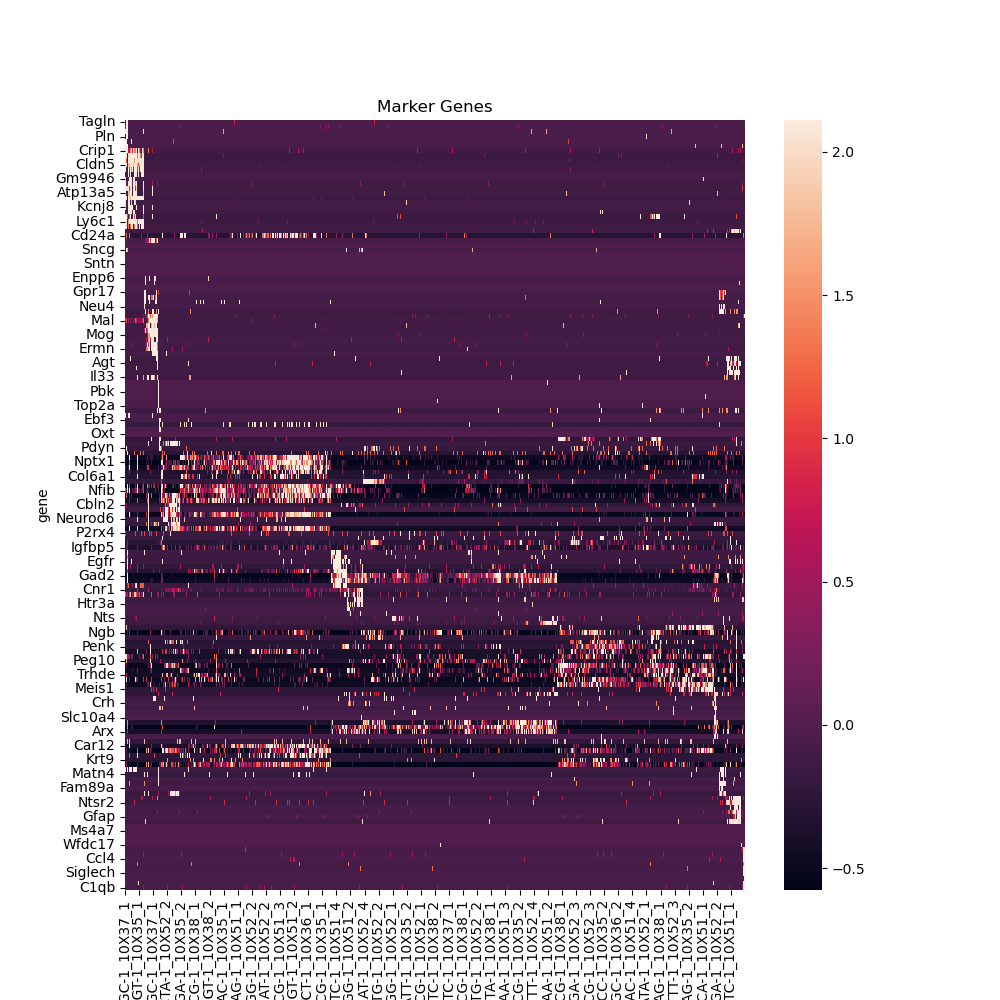

In [457]:
ax, fig = plt.subplots(figsize = (10,10))
#set robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values
#to display all ticks, use: xticklabels=True, yticklabels=True
plt.title('Marker Genes')
sns.heatmap(df_marker_log_and_std, robust=True)
plt.show()

Update plot to show average cluster position

In [458]:
df_marker_log_and_std_col = pd.DataFrame(data = df_marker_log_and_std.to_numpy(), 
                                         index = df_marker_log_and_std.index,
                                        columns = list(meta_data_df.loc['cluster_label',:]))

In [459]:
df_marker_log_and_std_col.head()

18         18         18         18         18         18  \
gene                                                                      
Tagln  15.580426   6.208216   5.427199  18.704496  15.580426  18.704496   
Acta2  14.609072   7.690904   5.656148  10.946512  26.003703  18.271632   
Myh11  50.400263  12.969221   8.086911   3.204601  11.341784  16.224094   
Pln     8.368892   4.163104  25.192043  -0.042683  50.426769   8.368892   
Gkn3   30.159628   1.028789  10.739069  13.975828   5.344469  -0.050131   

              18         18         18         18  ...        13        13  \
gene                                               ...                       
Tagln  17.923479  14.018391  14.799409  33.543829  ... -0.039924 -0.039924   
Acta2  23.155045  19.492485  16.643828  27.631507  ... -0.041167 -0.041167   
Myh11   8.086911   6.459474  29.243587  35.753333  ... -0.050272 -0.050272   
Pln     8.368892  12.574680  20.986255  12.574680  ... -0.042683 -0.042683   
Gkn3   29.080708  24.765028  15.054748  15.054748  ... -0.050131 -0.050131   

             13        13        13        13        13        13        13  \
gene                                                                          
Tagln -0.039924 -0.039924 -0.039924 -0.039924 -0.039924 -0.039924 -0.039924   
Acta2 -0.041167 -0.041167 -0.041167 -0.041167 -0.041167 -0.041167 -0.041167   
Myh11 -0.050272 -0.050272 -0.050272 -0.050272 -0.050272 -0.050272 -0.050272   
Pln   -0.042683 -0.042683 -0.042683 -0.042683 -0.042683 -0.042683 -0.042683   
Gkn3  -0.050131 -0.050131 -0.050131 -0.050131 -0.050131 -0.050131 -0.050131   

             13  
gene             
Tagln -0.039924  
Acta2 -0.041167  
Myh11 -0.050272  
Pln   -0.042683  
Gkn3  -0.050131  

[5 rows x 42764 columns]

In [460]:
x = list(meta_data_df.loc['cluster_label',:])
change_indices = [0]  # Initialize with the index of the first element

# Iterate through the list starting from the second element
for i in range(1, len(x)):
    # Check if the current value is different from the previous value
    if x[i] != x[i - 1]:
        # If a change is detected, append the index to the list
        change_indices.append(i)

print("Indices where the value changes:", change_indices)

change_indices = change_indices[1:] #ignore initial value set

Indices where the value changes: [0, 198, 806, 1279, 1334, 1473, 2205, 2295, 2358, 2457, 2505, 2627, 3810, 14208, 14233, 15298, 16422, 16442, 29778, 40565, 40613, 40958, 40995, 41447, 42485, 42561]


<IPython.core.display.Javascript object>


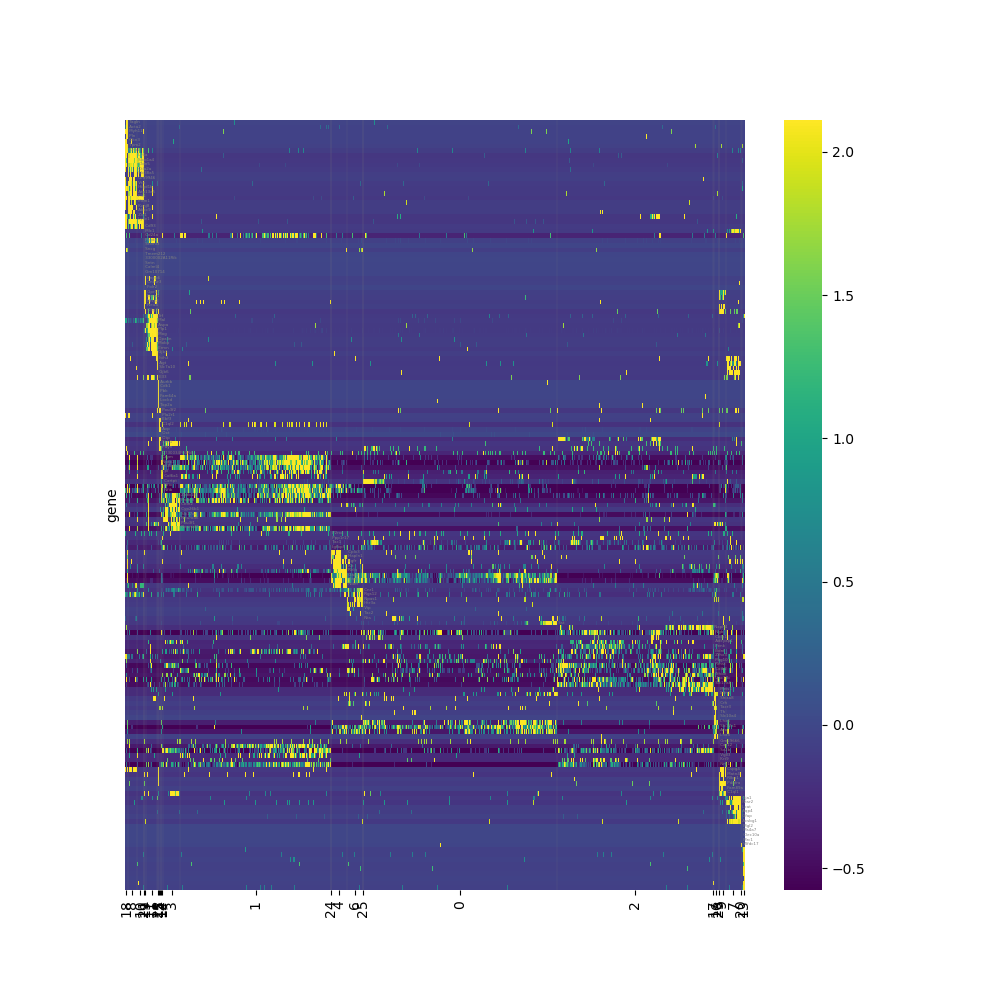

In [463]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_marker_log_and_std_col, robust=True,  cmap="viridis", yticklabels=True)
ax.set_xticks(ticks = pos, labels = linkage_cluster_order)
#ax.set_xticks([])
#ax.set_xticklabels([])
#ax.set_yticks(ticks = np.arange(0,len(df_marker_log_and_std_col.index)), labels = np.arange(0,len(df_marker_log_and_std_col.index)))
ax.set_yticks([])
ax.vlines(change_indices, -100 ,300, colors='gray', lw = 0.1)
#plt.text(change_indices[0],0, tgf_test, 
#             verticalalignment='top', horizontalalignment = 'left', color="white", fontsize = 2.9)

ypos = 0
#xpos = change_indices[0]

for i,v in enumerate(tg):
    xpos = change_indices[i]
    plt.text(xpos,ypos, tgfs[i], 
             verticalalignment='top', horizontalalignment = 'left', color="gray", fontsize = 2.9)
    ypos+=int(len(tg[i]))

    #print (xpos)
    
#plt.savefig('heatmap_test_linkage_'+linkage_alg+'_'+dist_metric+'.png', dpi = 1200)
#plt.savefig('heatmap_test_pre_linkage_ls'+linkage_alg+'_'+dist_metric+'.png', dpi = 1200)
#plt.savefig('heatmap_test_pre_linkage_ls_then_ns_w_hr_'+linkage_alg+'_'+dist_metric+'.png', dpi = 1200)

plt.show()

<IPython.core.display.Javascript object>


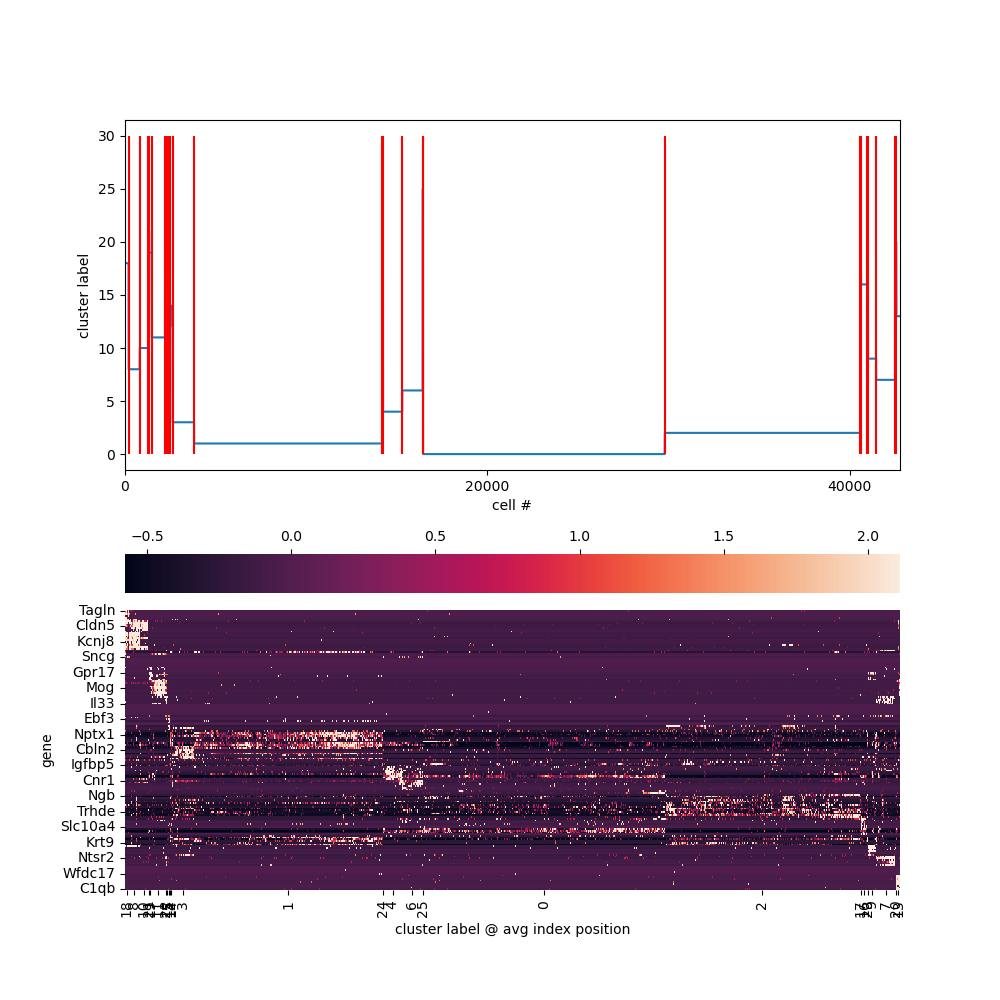

In [466]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
#set robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values
#to display all ticks, use: xticklabels=True, yticklabels=True

ax1.plot(np.array(meta_data_df.loc['cluster_label',:]))
ax1.set_xticks(ticks = [0, 20000, 40000])
ax1.margins(x=0)
ax1.set_xlabel('cell #')
ax1.set_ylabel('cluster label')
ax1.vlines(change_indices, 0 ,30, colors='r')

#plt.title('Heatmap using  column major F style')
#to move colorbar to top, add code below to .heatmap call
#cbar_kws=dict(location = 'top')
ax2 = sns.heatmap(df_marker_log_and_std_col, robust=True,cbar_kws=dict(location = 'top'))
ax2.set_xticks(ticks = pos, labels = linkage_cluster_order)
ax2.set_xlabel('cluster label @ avg index position')

plt.show()

In [133]:
df_marker_log_and_std_col

28        28         28         28        28        28  \
gene                                                                      
Itih3      6.870842  2.213731  -0.114825  11.527954  2.213731 -0.114825   
Slc7a10   -0.123340  6.616031   3.246346   3.246346  3.246346  3.246346   
Ptgds      4.833450  2.404507   3.445483   4.139466  0.149060  0.062312   
Il33      10.147138  3.294784   5.007873   6.720961 -0.131393  1.581696   
Gjb6       8.993686  2.910746  12.035157   2.910746  8.993686 -0.130725   
...             ...       ...        ...        ...       ...       ...   
Vtn       -0.103716 -0.103716  -0.103716  -0.103716 -0.103716 -0.103716   
Flt1      -0.144438 -0.144438  -0.144438  -0.144438 -0.144438 -0.144438   
Ndufa4l2  -0.128267 -0.128267  -0.128267  -0.128267 -0.128267 -0.128267   
Ly6c1     -0.153497 -0.153497  -0.153497  -0.153497 -0.153497 -0.153497   
Cd93      -0.110824 -0.110824  -0.110824  -0.110824 -0.110824 -0.110824   

                28        28        28         28  ...        11         11  \
gene                                               ...                        
Itih3     6.870842  9.199398 -0.114825   4.542287  ... -0.114825  -0.114825   
Slc7a10   3.246346  9.985717  6.616031   3.246346  ... -0.123340  -0.123340   
Ptgds     1.363532  1.016540  1.016540   1.276784  ... -0.024436  -0.024436   
Il33      6.720961  3.294784 -0.131393   3.294784  ... -0.131393  -0.131393   
Gjb6      5.952216 -0.130725  2.910746  12.035157  ... -0.130725  -0.130725   
...            ...       ...       ...        ...  ...       ...        ...   
Vtn      -0.103716 -0.103716 -0.103716  -0.103716  ... -0.103716  -0.103716   
Flt1     -0.144438 -0.144438 -0.144438  -0.144438  ...  7.171316  11.194980   
Ndufa4l2 -0.128267 -0.128267 -0.128267  -0.128267  ... -0.128267  -0.128267   
Ly6c1    -0.153497 -0.153497 -0.153497  -0.153497  ...  8.687687  12.965679   
Cd93     -0.110824 -0.110824 -0.110824  -0.110824  ...  5.581798  14.120730   

                 11        11         11         11         11         11  \
gene                                                                        
Itih3     -0.114825 -0.114825  -0.114825  -0.114825  -0.114825  -0.114825   
Slc7a10   -0.123340 -0.123340  -0.123340  -0.123340  -0.123340  -0.123340   
Ptgds     -0.111184 -0.111184  -0.111184  -0.111184  -0.111184  -0.111184   
Il33      -0.131393 -0.131393  -0.131393  -0.131393  -0.131393  -0.131393   
Gjb6      -0.130725 -0.130725  -0.130725  -0.130725  -0.130725  -0.130725   
...             ...       ...        ...        ...        ...        ...   
Vtn       -0.103716 -0.103716   0.737432  -0.103716   1.158006  -0.103716   
Flt1      13.938388  8.451572   7.354209  17.413371   9.000254   7.537103   
Ndufa4l2   1.399299 -0.128267  -0.128267   1.399299   1.399299  -0.128267   
Ly6c1     12.395280  7.261690  10.684083   8.972886  12.680480   3.839296   
Cd93       8.428108  7.004953  25.505973   5.581798  16.967040  12.697574   

                 11         11  
gene                            
Itih3     -0.114825  -0.114825  
Slc7a10   -0.123340  -0.123340  
Ptgds     -0.111184  -0.111184  
Il33      -0.131393  -0.131393  
Gjb6      -0.130725  -0.130725  
...             ...        ...  
Vtn        0.316858  -0.103716  
Flt1      15.584433  12.109449  
Ndufa4l2   1.399299  -0.128267  
Ly6c1      8.972886   9.543285  
Cd93      15.543885  29.775439  

[177 rows x 42647 columns]

<IPython.core.display.Javascript object>


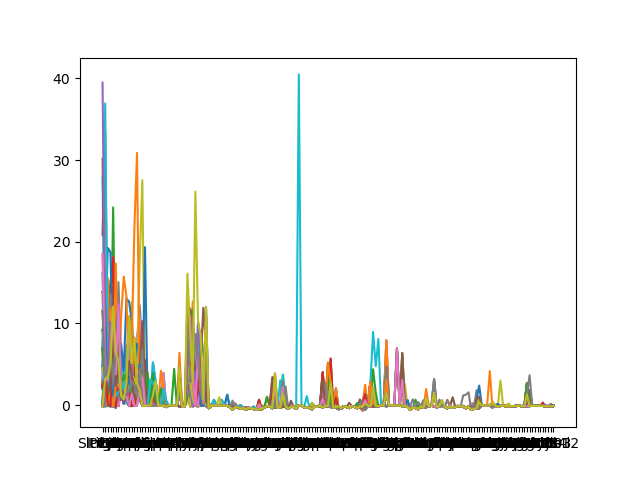

In [1353]:
fig,ax = plt.subplots()
#ax.plot(xi0p5_marker[:,linkage_cluster_order[0]])
ax.plot(df_marker_log_and_std_col.loc[:,df_marker_log_and_std_col.columns == 27])
plt.show()

Further analysis

In [1354]:
list(marker_genes_sorted)

['Itih3',
 'Slc7a10',
 'Ptgds',
 'Il33',
 'Gjb6',
 'Cd63',
 'Agt',
 'Plp1',
 'Mobp',
 'Mal',
 'Aspa',
 'Ermn',
 'Opalin',
 'Mog',
 'Trf',
 'Gjb1',
 'Bfsp2',
 'Neu4',
 'Bmp4',
 'Bcas1',
 'Cnksr3',
 'Folr2',
 'Gpr17',
 'Enpp6',
 'Otp',
 'Oxt',
 'Avp',
 'Ebf3',
 'Pla2r1',
 'Pou3f2',
 'Pdyn',
 'C1ql2',
 'Apoe',
 'Ntsr2',
 'Mlc1',
 'Lcat',
 'Slc25a18',
 'Aqp4',
 'Gfap',
 'Gja1',
 'Junb',
 'Ctss',
 'C1qa',
 'Bcl2a1b',
 'C1qc',
 'C1qb',
 'Siglech',
 'Cx3cr1',
 'Vgll3',
 'Ngb',
 'Penk',
 'Krt9',
 'Bhlhe22',
 'Cd24a',
 'Nptx1',
 'Lpl',
 'Car12',
 'Crym',
 'Ntng1',
 'Rmst',
 'Slc17a7',
 'Krt12',
 'Cyp26b1',
 'Neurod6',
 'Igfbp5',
 'Rorb',
 'Rasgrp1',
 '3110035E14Rik',
 'Pou3f1',
 'C1ql1',
 'Neurod2',
 'Cbln2',
 'Sim1',
 'Calb2',
 'Clec10a',
 'Mgl2',
 'Adcyap1',
 'Igfbp6',
 'Egr4',
 'Unc13c',
 'Npas4',
 'Fosb',
 'Snca',
 'Prox1',
 'Grp',
 'Fbln1',
 'Prox1os',
 'Rasl10a',
 'Meis1',
 'Slc17a6',
 'Hs3st4',
 'Abi3bp',
 'Nxph4',
 'Etl4',
 'Rxfp1',
 'Nr4a2',
 'Bdnf',
 'Dcn',
 'Nfib',
 'Nfix',
 'Fam89a'

gene in df?  True
gene index:  [82]


<IPython.core.display.Javascript object>


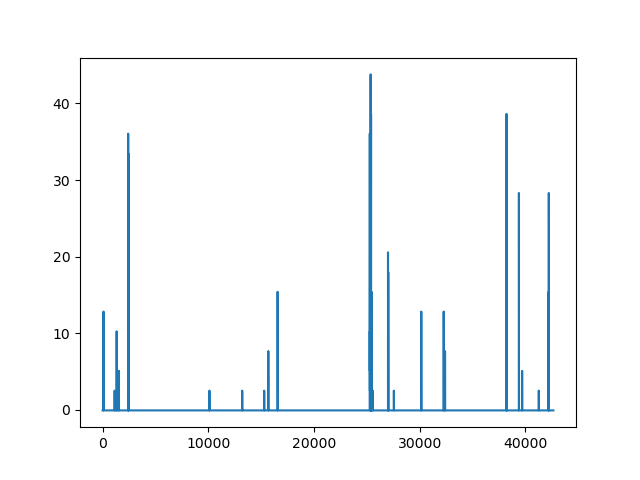

In [1355]:
gene = 'Snca'
print('gene in df? ', gene in df_marker_log_and_std.index)
gene_index = np.where(df_marker_log_and_std.index == gene)[0]
print ('gene index: ', gene_index)
#get row data
x = df_marker_log_and_std.iloc[gene_index,:]
fig,ax = plt.subplots()
plt.plot(np.array(x.iloc[0,:]))
plt.show()

In [1356]:
linkage_cluster_order

array([27, 14, 23,  6,  8, 17, 26, 13,  3,  4, 24, 20,  2, 16, 12,  7,  5,
        1, 29, 18, 10, 25, 15, 28,  0, 19, 22, 21,  9, 11], dtype=int32)

<IPython.core.display.Javascript object>


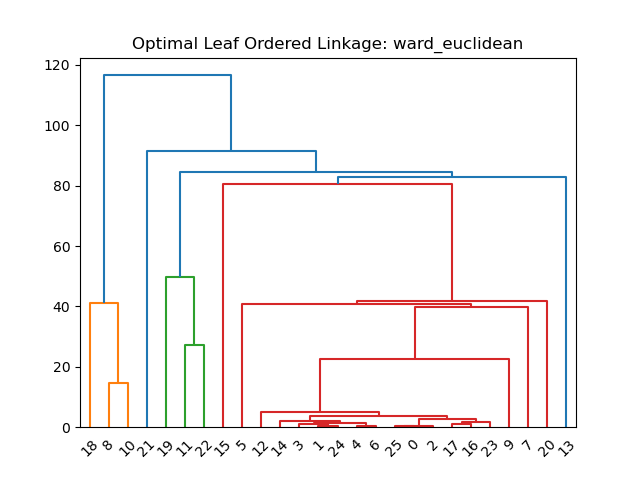

<IPython.core.display.Javascript object>


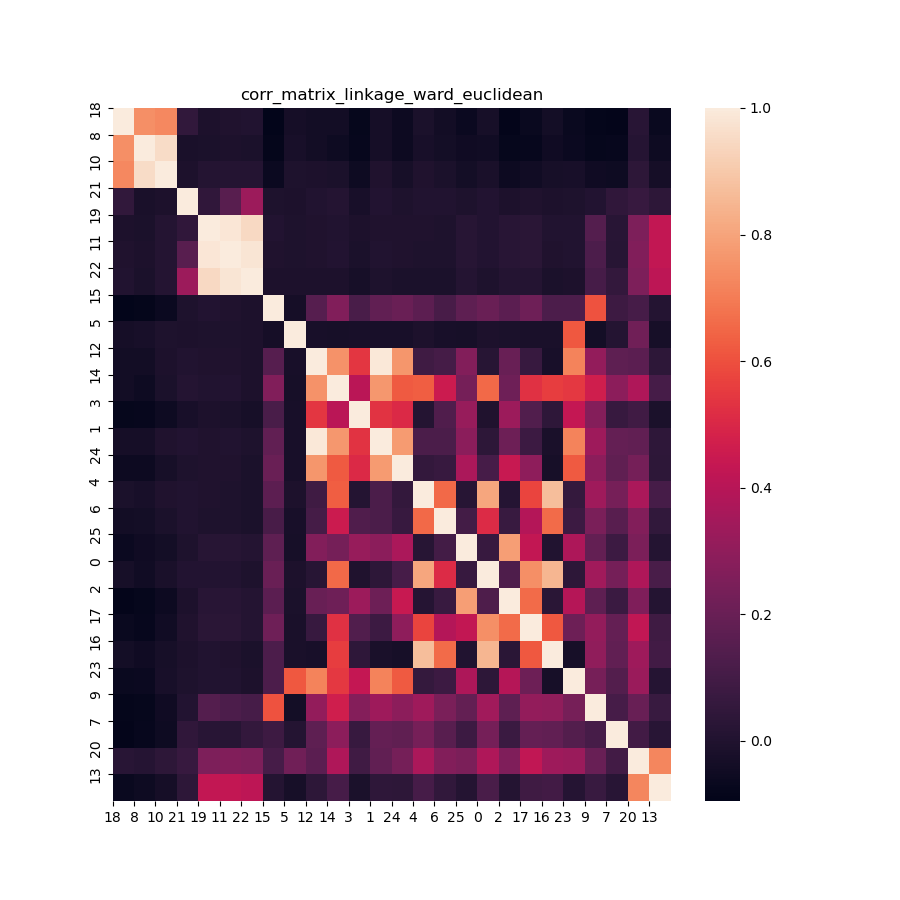

In [465]:
mean_per_gene_per_cluster_arr = np.zeros((len(df_marker_log_and_std_col.index),len(unique_labels)))
for idx, c in enumerate(zip(linkage_cluster_order,cluster_indices)):
    #compute mean expression for each cluster in linkage cluster order
    #print (idx)
    #print (c[0])
    cluster_mean_expr = np.mean(df_marker.loc[:,meta_data_df.loc['cluster_label',:] == c[0]], axis = 1)
    #print (cluster_mean_expr)
    mean_per_gene_per_cluster_arr[:,idx] = cluster_mean_expr

mean_per_gene_per_cluster_df = pd.DataFrame(data = mean_per_gene_per_cluster_arr)
fig,ax = plt.subplots()
#plt.figure(figsize=(10,10))
ax.set_title('Optimal Leaf Ordered Linkage: ' + linkage_alg + '_' + dist_metric)
dn = dendrogram(Z_ordered)
plt.show()

fig,ax = plt.subplots(figsize = (9,9))
ax = sns.heatmap(mean_per_gene_per_cluster_df.corr())
ax.set_title('corr_matrix_linkage_'+linkage_alg+'_'+dist_metric)
ax.set_xticks(ticks = np.arange(0,len(linkage_cluster_order)), labels = linkage_cluster_order)
ax.set_yticks(ticks = np.arange(0,len(linkage_cluster_order)), labels = linkage_cluster_order)
plt.savefig('corr_matrix_linkage_intra_sort_w_hr'+linkage_alg+'_'+dist_metric)
plt.show()

In [135]:
mean_per_gene_per_cluster_df.corr()

0         1         2         3         4         5         6   \
0   1.000000  0.962143  0.925420 -0.012889  0.208295  0.403568 -0.006099   
1   0.962143  1.000000  0.985270 -0.008335  0.010174  0.398852  0.008026   
2   0.925420  0.985270  1.000000 -0.008235  0.007155  0.394671  0.007338   
3  -0.012889 -0.008335 -0.008235  1.000000 -0.002157 -0.024031  0.610819   
4   0.208295  0.010174  0.007155 -0.002157  1.000000  0.136674  0.044068   
5   0.403568  0.398852  0.394671 -0.024031  0.136674  1.000000  0.033885   
6  -0.006099  0.008026  0.007338  0.610819  0.044068  0.033885  1.000000   
7  -0.026958 -0.016634 -0.015483 -0.021635  0.026357 -0.007897  0.364326   
8  -0.024994 -0.012607 -0.009657 -0.018463 -0.009410 -0.011463  0.274841   
9  -0.008573  0.007105  0.007621 -0.011919  0.082398  0.129114  0.074829   
10  0.011540  0.017681  0.016630 -0.018701  0.097850  0.087603  0.317890   
11  0.035793  0.046953  0.048941 -0.016533  0.048988  0.091272  0.355929   
12  0.017537  0.031793  0.033122 -0.014557  0.028447  0.049739  0.362741   
13 -0.020790 -0.007793 -0.005564 -0.014093 -0.003343  0.332805  0.178206   
14 -0.004998  0.006215  0.005915 -0.025407  0.049850  0.046280  0.465644   
15 -0.013451 -0.007325 -0.009595 -0.026123  0.049776  0.112137  0.500895   
16 -0.017049 -0.005112 -0.003387 -0.017876  0.006560  0.029688  0.207986   
17 -0.004641  0.004287  0.002332 -0.020371  0.062809  0.065728  0.716710   
18 -0.017691 -0.006470 -0.007357 -0.026457  0.036306  0.168519  0.611579   
19 -0.013793  0.002509  0.001750 -0.029325  0.099703  0.116527  0.516622   
20  0.153703  0.080229  0.100136 -0.036911  0.439282  0.113635  0.207351   
21  0.060798 -0.003717  0.006050 -0.023533  0.310833  0.029280  0.026186   
22 -0.021667 -0.008214 -0.008174 -0.018542  0.067127  0.085412  0.045035   
23 -0.019476 -0.006604 -0.006183 -0.019621  0.071667  0.094367  0.044652   
24 -0.025611 -0.011867 -0.011859 -0.021285  0.037115  0.060680 -0.007167   
25 -0.015983 -0.001693 -0.000820 -0.018179  0.042480  0.071893 -0.024810   
26 -0.016157 -0.000987  0.000351 -0.019545  0.059541  0.080954 -0.024684   
27 -0.021219 -0.011308 -0.009773 -0.016264  0.034331  0.029570 -0.000633   
28  0.011473  0.015073  0.014947 -0.021044 -0.000754  0.095298  0.011935   
29 -0.004276 -0.011401 -0.015054 -0.026270  0.023914  0.046334 -0.053792   
30  0.015001  0.009768  0.005289 -0.009561  0.025756  0.042295 -0.018841   

          7         8         9   ...        21        22        23        24  \
0  -0.026958 -0.024994 -0.008573  ...  0.060798 -0.021667 -0.019476 -0.025611   
1  -0.016634 -0.012607  0.007105  ... -0.003717 -0.008214 -0.006604 -0.011867   
2  -0.015483 -0.009657  0.007621  ...  0.006050 -0.008174 -0.006183 -0.011859   
3  -0.021635 -0.018463 -0.011919  ... -0.023533 -0.018542 -0.019621 -0.021285   
4   0.026357 -0.009410  0.082398  ...  0.310833  0.067127  0.071667  0.037115   
5  -0.007897 -0.011463  0.129114  ...  0.029280  0.085412  0.094367  0.060680   
6   0.364326  0.274841  0.074829  ...  0.026186  0.045035  0.044652 -0.007167   
7   1.000000  0.566171  0.091636  ... -0.035778 -0.008598 -0.011104 -0.010388   
8   0.566171  1.000000  0.005664  ...  0.036336 -0.034975 -0.033175 -0.034841   
9   0.091636  0.005664  1.000000  ... -0.024613  0.807486  0.834142  0.602264   
10  0.218993  0.146314  0.466321  ...  0.021062  0.363840  0.340955  0.230409   
11  0.493146  0.151964  0.207880  ... -0.034830 -0.006328 -0.006788  0.004749   
12  0.412327  0.179980  0.181178  ... -0.061610 -0.017764 -0.019962  0.002017   
13  0.237252  0.115461  0.124422  ...  0.001012 -0.030566 -0.029049 -0.022685   
14  0.873369  0.353594  0.177826  ...  0.000908  0.057613  0.054227  0.028994   
15  0.194543  0.142370  0.086445  ...  0.107554  0.123530  0.121684  0.027137   
16  0.191524  0.248715  0.081539  ... -0.042378  0.014321 -0.013413  0.002346   
17  0.399934  0.328497  0.077474  ...  0.094910  0.108446  0.109768  0.025458   
18  0.280443  0.300452  0.054289  ... 

In [136]:
mpg_pca_pl_df.corr()

28        14        24        6         8         17        27  \
28  1.000000  0.944637  0.888119 -0.006047  0.287171  0.347138  0.014978   
14  0.944637  1.000000  0.959599 -0.002040  0.022363  0.322823  0.023580   
24  0.888119  0.959599  1.000000 -0.003660  0.024925  0.312812  0.026581   
6  -0.006047 -0.002040 -0.003660  1.000000  0.001903 -0.009308  0.486808   
8   0.287171  0.022363  0.024925  0.001903  1.000000  0.185198  0.094908   
17  0.347138  0.322823  0.312812 -0.009308  0.185198  1.000000  0.084525   
27  0.014978  0.023580  0.026581  0.486808  0.094908  0.084525  1.000000   
13 -0.001163  0.005165  0.000816 -0.002708  0.068464  0.047754  0.509456   
3  -0.003377  0.005014  0.004901 -0.001630  0.041728  0.050283  0.416068   
4   0.006266  0.018207  0.020021  0.006202  0.100517  0.131246  0.235185   
25  0.032636  0.029388  0.027937  0.002089  0.143122  0.124219  0.493724   
20  0.043070  0.048592  0.058036  0.003940  0.095470  0.105794  0.529847   
2   0.027695  0.034136  0.041556  0.008005  0.097256  0.086619  0.555256   
16 -0.002789  0.008467  0.010957  0.006512  0.036332  0.268661  0.303252   
12  0.014813  0.022632  0.022145 -0.001532  0.089047  0.087790  0.616867   
7   0.004383  0.010113  0.011374 -0.005719  0.060584  0.103974  0.513341   
5  -0.004029  0.006262  0.009000  0.005054  0.055630  0.070766  0.364245   
1   0.007649  0.014701  0.011369 -0.003036  0.090327  0.096790  0.790434   
30 -0.003528  0.006606  0.002124 -0.004433  0.070371  0.154294  0.705354   
18  0.006770  0.018681  0.018301 -0.004031  0.120744  0.136562  0.679945   
10  0.174165  0.066677  0.103084 -0.008085  0.445852  0.133527  0.218885   
26  0.110822  0.019281  0.040200 -0.008737  0.347282  0.066097  0.049368   
15 -0.000428  0.009086  0.006324 -0.002310  0.067514  0.091222  0.133738   
29  0.010542  0.015304  0.011442 -0.006112  0.080673  0.113783  0.118254   
0  -0.007296  0.003750  0.002307 -0.005539  0.049537  0.076592  0.086579   
19 -0.002855  0.010600  0.010963 -0.003676  0.046182  0.080962  0.076113   
21 -0.000552  0.008693  0.007034  0.002434  0.081073  0.083002  0.167331   
23 -0.009367  0.000423  0.002334 -0.002254  0.038453  0.047260  0.078727   
22  0.035501  0.025086  0.019552 -0.008597  0.053453  0.102325  0.062580   
9   0.037283 -0.003842 -0.012669 -0.014689  0.136457  0.101758 -0.051583   
11  0.015582  0.004883 -0.002710 -0.006548  0.040392  0.081595 -0.034845   

          13        3         4   ...        26        15        29        0   \
28 -0.001163 -0.003377  0.006266  ...  0.110822 -0.000428  0.010542 -0.007296   
14  0.005165  0.005014  0.018207  ...  0.019281  0.009086  0.015304  0.003750   
24  0.000816  0.004901  0.020021  ...  0.040200  0.006324  0.011442  0.002307   
6  -0.002708 -0.001630  0.006202  ... -0.008737 -0.002310 -0.006112 -0.005539   
8   0.068464  0.041728  0.100517  ...  0.347282  0.067514  0.080673  0.049537   
17  0.047754  0.050283  0.131246  ...  0.066097  0.091222  0.113783  0.076592   
27  0.509456  0.416068  0.235185  ...  0.049368  0.133738  0.118254  0.086579   
13  1.000000  0.679947  0.189495  ...  0.059516  0.070116  0.079727  0.096280   
3   0.679947  1.000000  0.114851  ...  0.062664  0.044695  0.059005  0.058453   
4   0.189495  0.114851  1.000000  ...  0.037511  0.732033  0.740464  0.602997   
25  0.377935  0.262786  0.545765  ...  0.109652  0.341718  0.331784  0.281757   
20  0.492369  0.240424  0.343830  ...  0.059825  0.071616  0.070588  0.103120   
2   0.453681  0.248233  0.378641  ...  0.060487  0.081176  0.073289  0.120383   
16  0.291565  0.146255  0.265620  ...  0.031033  0.040418  0.041814  0.076608   
12  0.868503  0.525492  0.285371  ...  0.067546  0.133929  0.139750  0.132907   
7   0.380060  0.570632  0.113406  ...  0.061481  0.117920  0.115623  0.056957   
5   0.334644  0.416956  0.258620  ...  0.045740  0.076071  0.056593  0.093348   
1   0.535744  0.526564  0.169967  ...  0.067886  0.164923  0.153339  0.080582   
30  0.459511  0.489984  0.181929  ... 

## Cluster/Cell Labeling <a name="labeling"></a>

### Initialization of relevant marker genes corresponding to class types <a name="classinit"></a>

4 Main Cell types of interest - Vglut1, Vglut2, GABA, and non-neuronal

In [477]:
Vglut1_marker = 'Slc17a7'

Vglut2_marker = 'Slc17a6'

GABA_marker = 'Gad2'

exclude_markers = ['C1qc','C1qa','C1qb','Gja1','Cx3cr1','Acta2','Ly6c1',
                   'Mfge8','Plxnb3','Cldn11','Aqp4','Vtn','Cldn5',
                   'Pdgfrb','Flt1','Slc25a18','Pdgfra','Foxj1',
                   'Olig1','Olig2','Sox10','Hbb-bs','Hbb-bt',
                   'Hba-a2','Ttr']



Sanity check that markers are in df_marker

In [575]:
Vglut1_marker in df_marker.index

True

In [576]:
Vglut2_marker in df_marker.index

True

In [577]:
GABA_marker in df_marker.index

True

Check non-neuronal, create new exclude_markers_updated list for exclude markers found in df_marker

In [585]:
exclude_markers_updated = []
for g in exclude_markers:
    print (g, g in df_marker.index)
    if g in df_marker.index:
        exclude_markers_updated.append(g)

C1qc True
C1qa True
C1qb True
Gja1 True
Cx3cr1 True
Acta2 True
Ly6c1 True
Mfge8 False
Plxnb3 False
Cldn11 False
Aqp4 True
Vtn True
Cldn5 True
Pdgfrb False
Flt1 True
Slc25a18 False
Pdgfra True
Foxj1 False
Olig1 False
Olig2 True
Sox10 False
Hbb-bs False
Hbb-bt False
Hba-a2 False
Ttr False


In [586]:
exclude_markers_updated

['C1qc',
 'C1qa',
 'C1qb',
 'Gja1',
 'Cx3cr1',
 'Acta2',
 'Ly6c1',
 'Aqp4',
 'Vtn',
 'Cldn5',
 'Flt1',
 'Pdgfra',
 'Olig2']

In [479]:
df_marker.shape

(163, 42764)

In [478]:
df_marker.head()

CTTCTCTTCACAATGC-1_10X37_1  AATGGCTGTTGGCTAT-1_10X38_1  \
gene                                                            
Tagln                          20                           8   
Acta2                          36                          19   
Myh11                          31                           8   
Pln                             2                           1   
Gkn3                           28                           1   

       ATGACCACACATTGTG-1_10X35_2  CTGCATCCAAATGGTA-1_10X52_3  \
gene                                                            
Tagln                           7                          24   
Acta2                          14                          27   
Myh11                           5                           2   
Pln                             6                           0   
Gkn3                           10                          13   

       ACCAACACAGCTCGGT-1_10X37_1  CGAGAAGGTTCAGCGC-1_10X52_3  \
gene                                                            
Tagln                          20                          24   
Acta2                          64                          45   
Myh11                           7                          10   
Pln                            12                           2   
Gkn3                            5                           0   

       TACTGCCGTCTCCCTA-1_10X38_1  TCATTTGAGCTGCGAA-1_10X37_1  \
gene                                                            
Tagln                          23                          18   
Acta2                          57                          48   
Myh11                           5                           4   
Pln                             2                           3   
Gkn3                           27                          23   

       TTCGATTTCCATCTCG-1_10X38_1  GGTAGAGAGAGGATGA-1_10X37_2  ...  \
gene                                                           ...   
Tagln                          19                          43  ...   
Acta2                          41                          68  ...   
Myh11                          18                          22  ...   
Pln                             5                           3  ...   
Gkn3                           14                          14  ...   

       GTTGAACGTCCTATAG-1_10X35_2  ATGCGATAGGTTAAAC-1_10X35_1  \
gene                                                            
Tagln                           0                           0   
Acta2                           0                           0   
Myh11                           0                           0   
Pln                             0                           0   
Gkn3                            0                           0   

       GTCCACTGTTGCTCAA-1_10X38_1  CGTAAGTGTAGATCGG-1_10X37_2  \
gene                                                            
Tagln                           0                           0   
Acta2                           0                           0   
Myh11                           0                           0   
Pln                             0                           0   
Gkn3                            0                           0   

       TGACGCGTCCTATTTG-1_10X51_2  GTCAAACGTCAACCAT-1_10X52_2  \
gene                                                            
Tagln                           0                           0   
Acta2                           0                           0   
Myh11                           0                           0   
Pln                             0                           0   
Gkn3                            0                           0   

       TGTCAGACACACGGTC-1_10X52_2  GATCCCTTCGTAGCTA-1_10X35_2  \
gene                                                            
Tagln                           0                           0   
Acta2                           0                           0   
Myh11                           0                           0   

In [494]:
meta_data_df.tail()

CTTCTCTTCACAATGC-1_10X37_1 AATGGCTGTTGGCTAT-1_10X38_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.9                       15.0   
lengthbp_seqlib                             440.0                      420.0   
Sample_Index                                   E9                         B9   
cluster_label                                  18                         18   

                       ATGACCACACATTGTG-1_10X35_2 CTGCATCCAAATGGTA-1_10X52_3  \
LIbConstructionComment                                                         
ngperul_seqlib                               17.6          20.4(second prep)   
lengthbp_seqlib                             461.0                      507.0   
Sample_Index                                   G8                        F12   
cluster_label                                  18                         18   

                       ACCAACACAGCTCGGT-1_10X37_1 CGAGAAGGTTCAGCGC-1_10X52_3  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.9          20.4(second prep)   
lengthbp_seqlib                             440.0                      507.0   
Sample_Index                                   E9                        F12   
cluster_label                                  18                         18   

                       TACTGCCGTCTCCCTA-1_10X38_1 TCATTTGAGCTGCGAA-1_10X37_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.0                       15.9   
lengthbp_seqlib                             420.0                      440.0   
Sample_Index                                   B9                         E9   
cluster_label                                  18                         18   

                       TTCGATTTCCATCTCG-1_10X38_1 GGTAGAGAGAGGATGA-1_10X37_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.0                       16.0   
lengthbp_seqlib                             420.0                      460.0   
Sample_Index                                   B9                         F9   
cluster_label                                  18                         18   

                        ... GTTGAACGTCCTATAG-1_10X35_2  \
LIbConstructionComment  ...                              
ngperul_seqlib          ...                       17.6   
lengthbp_seqlib         ...                      461.0   
Sample_Index            ...                         G8   
cluster_label           ...                         13   

                       ATGCGATAGGTTAAAC-1_10X35_1 GTCCACTGTTGCTCAA-1_10X38_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               13.6                       15.0   
lengthbp_seqlib                             416.0                      420.0   
Sample_Index                                   D9                         B9   
cluster_label                                  13                         13   

                       CGTAAGTGTAGATCGG-1_10X37_2 TGACGCGTCCTATTTG-1_10X51_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               16.0                       22.2   
lengthbp_seqlib                             460.0                      474.0   
Sample_Index                                   F9                         A2   
cluster_label                                  13                         13   

                       GTCAAACGTCAACCAT-1_10X52_2 TGTCAGACACACGGTC-1_10X52_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               17.5                       17.5   
lengthbp_seqlib                             440.0                  

In [1029]:
# column sum of exclude marker, using original dataframe
df_ex_marker = df_pre_linkage_ls.T.loc[exclude_markers_updated,:]
nonneuro = df_ex_marker.sum(axis = 0)
nonneuro

AAACCCAAGAGCATAT-1_10X51_2   -1.845174
TATTTCGGTTCATCGA-1_10X51_3   -1.845174
TATTTCGTCCACCTGT-1_10X51_3   -1.845174
TCAAGACTCCTAAGTG-1_10X51_3   -1.845174
TCAAGCATCGTCTAAG-1_10X51_3   -1.845174
                                ...   
AGACCATGTTGAATCC-1_10X52_1   -1.845174
TTGTTGTCAAGTGGTG-1_10X52_2    0.334083
ACAGAAATCTCGTCAC-1_10X52_1   -1.845174
GTGGAAGGTGGGTCAA-1_10X51_2   -1.845174
CGAATTGAGCCTGGAA-1_10X52_1   -1.845174
Length: 42764, dtype: float64

In [658]:
#dictionary mapping flag to class type
flag_dict = {1:'GABA', 2:'Vglut1', 3:'Vglut2', 4:'Nonneuronal' , 5:'Doublet'}

In [555]:
#initialize flag vector to store flags correspondings class type for each cluster
gabaglut = np.zeros((1,len(linkage_cluster_order)))[0]
gabaglut

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [844]:
#intialize empty cell class dataframe to be added to meta data, indicating class type for each cell
cell_class = pd.DataFrame(columns=meta_data_df.columns, index = ['cell_class'])

In [845]:
cell_class

CTTCTCTTCACAATGC-1_10X37_1 AATGGCTGTTGGCTAT-1_10X38_1  \
cell_class                        NaN                        NaN   

           ATGACCACACATTGTG-1_10X35_2 CTGCATCCAAATGGTA-1_10X52_3  \
cell_class                        NaN                        NaN   

           ACCAACACAGCTCGGT-1_10X37_1 CGAGAAGGTTCAGCGC-1_10X52_3  \
cell_class                        NaN                        NaN   

           TACTGCCGTCTCCCTA-1_10X38_1 TCATTTGAGCTGCGAA-1_10X37_1  \
cell_class                        NaN                        NaN   

           TTCGATTTCCATCTCG-1_10X38_1 GGTAGAGAGAGGATGA-1_10X37_2  ...  \
cell_class                        NaN                        NaN  ...   

           GTTGAACGTCCTATAG-1_10X35_2 ATGCGATAGGTTAAAC-1_10X35_1  \
cell_class                        NaN                        NaN   

           GTCCACTGTTGCTCAA-1_10X38_1 CGTAAGTGTAGATCGG-1_10X37_2  \
cell_class                        NaN                        NaN   

           TGACGCGTCCTATTTG-1_10X51_2 GTCAAACGTCAACCAT-1_10X52_2  \
cell_class                        NaN                        NaN   

           TGTCAGACACACGGTC-1_10X52_2 GATCCCTTCGTAGCTA-1_10X35_2  \
cell_class                        NaN                        NaN   

           AAACGAAGTACAAGCG-1_10X36_1 GAGATGGTCCTTATAC-1_10X52_3  
cell_class                        NaN                        NaN  

[1 rows x 42764 columns]

### Marker Mean Expression Calculation <a name="classmean"></a>

In [949]:
#initialize lists to store mean of each marker within each cluster
mu_g = []
mu_vg1 = []
mu_vg2 = []
mu_nn = []

#std dev of mean of each marker within each cluster
std_g = []
std_vg1 = []
std_vg2 = []
std_nn = []

#loop through each cluster
for i,c in enumerate(linkage_cluster_order):
    #extract expression data of cluster c
    tmp = df_marker.iloc[:,np.where(meta_data_df.loc['cluster_label']==c)[0]]
    #get row means for markers within cluster
    GABA_marker_mean = np.mean(tmp.loc[GABA_marker,:])
    Vglut1_marker_mean = np.mean(tmp.loc[Vglut1_marker,:])
    Vglut2_marker_mean = np.mean(tmp.loc[Vglut2_marker,:])
    nonneuro_mean = np.mean(tmp.loc[exclude_markers_updated,:])
    
    #get row stds for markers within cluster
    GABA_marker_std = np.std(tmp.loc[GABA_marker,:])
    Vglut1_marker_std = np.std(tmp.loc[Vglut1_marker,:])
    Vglut2_marker_std = np.std(tmp.loc[Vglut2_marker,:])
    nonneuro_std = np.std(tmp.loc[exclude_markers_updated,:])
    
    #append mean to respective list
    mu_g.append(GABA_marker_mean)
    mu_vg1.append(Vglut1_marker_mean)
    mu_vg2.append(Vglut2_marker_mean)
    mu_nn.append(nonneuro_mean)
    
    #append std to respective list
    std_g.append(GABA_marker_std)
    std_vg1.append(Vglut1_marker_std)
    std_vg2.append(Vglut2_marker_std)
    std_nn.append(nonneuro_std)    
    
    #sort means descending
    marker_means = np.flip(np.sort(np.array([GABA_marker_mean,
                                             Vglut1_marker_mean,
                                             Vglut2_marker_mean,
                                             nonneuro_mean])))
    print (marker_means)
    
    #classify cluster based on greatest mean, adding flag to gabaglut, and corresponding class type to cell_class
    if marker_means[0]>2*marker_means[1]:
        if marker_means[0] == GABA_marker_mean:
            #print ('gaba', GABA_marker_mean)
            gabaglut[i] = 1
            cell_class.iloc[:,np.where(meta_data_df.loc['cluster_label']==c)[0]] = flag_dict[1]
        if marker_means[0] == Vglut1_marker_mean:
            #print ('vglut1', Vglut1_marker_mean)
            gabaglut[i] = 2
            cell_class.iloc[:,np.where(meta_data_df.loc['cluster_label']==c)[0]] = flag_dict[2]
        if marker_means[0] == Vglut2_marker_mean:
            #print ('vglut2', Vglut2_marker_mean)
            gabaglut[i] = 3
            cell_class.iloc[:,np.where(meta_data_df.loc['cluster_label']==c)[0]] = flag_dict[3]
        if marker_means[0] == nonneuro_mean:
            #print ('nonneuro', nonneuro_mean)
            gabaglut[i] = 4
            cell_class.iloc[:,np.where(meta_data_df.loc['cluster_label']==c)[0]] = flag_dict[4]
    #if first mean is not at least 2x second mean in descending list, flag clustter as doublet
    #note factor of two is arbitrary...
    else:
        gabaglut[i] = 5
        cell_class.iloc[:,np.where(meta_data_df.loc['cluster_label']==c)[0]] = flag_dict[5]
    #print (tmp.shape)
    


/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do no

[6.28904429 1.52525253 0.76262626 0.24747475]
[7.23861336 0.59868421 0.24342105 0.13980263]
[5.32493088 1.07610994 0.56659619 0.33192389]


/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do no

[1.61818182 1.22377622 0.58181818 0.45454545]
[1.92805755 0.39568345 0.30935252 0.30824571]
[2.63661202 0.93442623 0.73224044 0.13114754]


/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do no

[0.71367521 0.21111111 0.14444444 0.04444444]
[1.52380952 0.9047619  0.6043956  0.31746032]
[2.1010101  0.22222222 0.13131313 0.01243201]
[9.35416667e+00 1.04166667e-01 1.04166667e-01 8.01282051e-03]


/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do no

[13.06557377  8.44262295  0.36065574  0.01891551]
[10.32290786  2.81994928  0.42180896  0.01202939]
[6.96191575 0.28640123 0.19311406 0.01098584]
[4.8        1.2        0.04       0.01230769]


/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do no

[2.40938967e+01 1.21126761e-01 9.29577465e-02 1.04008667e-02]
[1.08069395e+01 1.37900356e-01 6.04982206e-02 8.34930194e-03]
[2.25       0.1        0.05       0.01153846]


/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


[1.09735303e+01 7.93341332e-02 4.76904619e-02 9.32121268e-03]
[4.04718643 0.33234449 0.2681932  0.01075368]
[11.0625      4.58333333  0.14583333  0.02083333]


/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do no

[1.66318841e+01 1.82608696e-01 2.60869565e-02 1.29319955e-02]
[8.48648649 4.51351351 0.21621622 0.02079002]
[2.61946903 1.29646018 0.74115044 0.60772634]


/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/isaac/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do no

[3.44797688 1.38439306 1.04179635 0.84874759]
[3.60526316 1.14271255 1.01315789 0.71052632]
[4.51231527 4.27207275 1.45812808 0.73891626]


In [847]:
gabaglut

array([4., 4., 4., 5., 1., 1., 4., 5., 3., 2., 5., 2., 2., 2., 1., 1., 3.,
       1., 3., 1., 1., 5., 1., 1., 1., 5.])

In [848]:
#use flag dict to convert flag vector to list of class type
gabaglut_l = [flag_dict[i] for i in gabaglut]
gabaglut_l

['Nonneuronal',
 'Nonneuronal',
 'Nonneuronal',
 'Doublet',
 'GABA',
 'GABA',
 'Nonneuronal',
 'Doublet',
 'Vglut2',
 'Vglut1',
 'Doublet',
 'Vglut1',
 'Vglut1',
 'Vglut1',
 'GABA',
 'GABA',
 'Vglut2',
 'GABA',
 'Vglut2',
 'GABA',
 'GABA',
 'Doublet',
 'GABA',
 'GABA',
 'GABA',
 'Doublet']

In [849]:
# create another dictionary mapping cluster label to class type
label_to_class_map = dict(zip(linkage_cluster_order, gabaglut_l))

In [850]:
label_to_class_map

{18: 'Nonneuronal',
 8: 'Nonneuronal',
 10: 'Nonneuronal',
 21: 'Doublet',
 19: 'GABA',
 11: 'GABA',
 22: 'Nonneuronal',
 15: 'Doublet',
 5: 'Vglut2',
 12: 'Vglut1',
 14: 'Doublet',
 3: 'Vglut1',
 1: 'Vglut1',
 24: 'Vglut1',
 4: 'GABA',
 6: 'GABA',
 25: 'Vglut2',
 0: 'GABA',
 2: 'Vglut2',
 17: 'GABA',
 16: 'GABA',
 23: 'Doublet',
 9: 'GABA',
 7: 'GABA',
 20: 'GABA',
 13: 'Doublet'}

In [851]:
cell_class

CTTCTCTTCACAATGC-1_10X37_1 AATGGCTGTTGGCTAT-1_10X38_1  \
cell_class                Nonneuronal                Nonneuronal   

           ATGACCACACATTGTG-1_10X35_2 CTGCATCCAAATGGTA-1_10X52_3  \
cell_class                Nonneuronal                Nonneuronal   

           ACCAACACAGCTCGGT-1_10X37_1 CGAGAAGGTTCAGCGC-1_10X52_3  \
cell_class                Nonneuronal                Nonneuronal   

           TACTGCCGTCTCCCTA-1_10X38_1 TCATTTGAGCTGCGAA-1_10X37_1  \
cell_class                Nonneuronal                Nonneuronal   

           TTCGATTTCCATCTCG-1_10X38_1 GGTAGAGAGAGGATGA-1_10X37_2  ...  \
cell_class                Nonneuronal                Nonneuronal  ...   

           GTTGAACGTCCTATAG-1_10X35_2 ATGCGATAGGTTAAAC-1_10X35_1  \
cell_class                    Doublet                    Doublet   

           GTCCACTGTTGCTCAA-1_10X38_1 CGTAAGTGTAGATCGG-1_10X37_2  \
cell_class                    Doublet                    Doublet   

           TGACGCGTCCTATTTG-1_10X51_2 GTCAAACGTCAACCAT-1_10X52_2  \
cell_class                    Doublet                    Doublet   

           TGTCAGACACACGGTC-1_10X52_2 GATCCCTTCGTAGCTA-1_10X35_2  \
cell_class                    Doublet                    Doublet   

           AAACGAAGTACAAGCG-1_10X36_1 GAGATGGTCCTTATAC-1_10X52_3  
cell_class                    Doublet                    Doublet  

[1 rows x 42764 columns]

In [860]:
meta_data_df.tail()

CTTCTCTTCACAATGC-1_10X37_1 AATGGCTGTTGGCTAT-1_10X38_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.9                       15.0   
lengthbp_seqlib                             440.0                      420.0   
Sample_Index                                   E9                         B9   
cluster_label                                  18                         18   

                       ATGACCACACATTGTG-1_10X35_2 CTGCATCCAAATGGTA-1_10X52_3  \
LIbConstructionComment                                                         
ngperul_seqlib                               17.6          20.4(second prep)   
lengthbp_seqlib                             461.0                      507.0   
Sample_Index                                   G8                        F12   
cluster_label                                  18                         18   

                       ACCAACACAGCTCGGT-1_10X37_1 CGAGAAGGTTCAGCGC-1_10X52_3  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.9          20.4(second prep)   
lengthbp_seqlib                             440.0                      507.0   
Sample_Index                                   E9                        F12   
cluster_label                                  18                         18   

                       TACTGCCGTCTCCCTA-1_10X38_1 TCATTTGAGCTGCGAA-1_10X37_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.0                       15.9   
lengthbp_seqlib                             420.0                      440.0   
Sample_Index                                   B9                         E9   
cluster_label                                  18                         18   

                       TTCGATTTCCATCTCG-1_10X38_1 GGTAGAGAGAGGATGA-1_10X37_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               15.0                       16.0   
lengthbp_seqlib                             420.0                      460.0   
Sample_Index                                   B9                         F9   
cluster_label                                  18                         18   

                        ... GTTGAACGTCCTATAG-1_10X35_2  \
LIbConstructionComment  ...                              
ngperul_seqlib          ...                       17.6   
lengthbp_seqlib         ...                      461.0   
Sample_Index            ...                         G8   
cluster_label           ...                         13   

                       ATGCGATAGGTTAAAC-1_10X35_1 GTCCACTGTTGCTCAA-1_10X38_1  \
LIbConstructionComment                                                         
ngperul_seqlib                               13.6                       15.0   
lengthbp_seqlib                             416.0                      420.0   
Sample_Index                                   D9                         B9   
cluster_label                                  13                         13   

                       CGTAAGTGTAGATCGG-1_10X37_2 TGACGCGTCCTATTTG-1_10X51_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               16.0                       22.2   
lengthbp_seqlib                             460.0                      474.0   
Sample_Index                                   F9                         A2   
cluster_label                                  13                         13   

                       GTCAAACGTCAACCAT-1_10X52_2 TGTCAGACACACGGTC-1_10X52_2  \
LIbConstructionComment                                                         
ngperul_seqlib                               17.5                       17.5   
lengthbp_seqlib                             440.0                  

In [858]:
#meta_data_df = meta_data_df.drop(['cell_class'])

In [861]:
#append cell class to metadata
meta_data_df = pd.concat([meta_data_df, cell_class])

In [863]:
meta_data_df.tail()

CTTCTCTTCACAATGC-1_10X37_1 AATGGCTGTTGGCTAT-1_10X38_1  \
ngperul_seqlib                        15.9                       15.0   
lengthbp_seqlib                      440.0                      420.0   
Sample_Index                            E9                         B9   
cluster_label                           18                         18   
cell_class                     Nonneuronal                Nonneuronal   

                ATGACCACACATTGTG-1_10X35_2 CTGCATCCAAATGGTA-1_10X52_3  \
ngperul_seqlib                        17.6          20.4(second prep)   
lengthbp_seqlib                      461.0                      507.0   
Sample_Index                            G8                        F12   
cluster_label                           18                         18   
cell_class                     Nonneuronal                Nonneuronal   

                ACCAACACAGCTCGGT-1_10X37_1 CGAGAAGGTTCAGCGC-1_10X52_3  \
ngperul_seqlib                        15.9          20.4(second prep)   
lengthbp_seqlib                      440.0                      507.0   
Sample_Index                            E9                        F12   
cluster_label                           18                         18   
cell_class                     Nonneuronal                Nonneuronal   

                TACTGCCGTCTCCCTA-1_10X38_1 TCATTTGAGCTGCGAA-1_10X37_1  \
ngperul_seqlib                        15.0                       15.9   
lengthbp_seqlib                      420.0                      440.0   
Sample_Index                            B9                         E9   
cluster_label                           18                         18   
cell_class                     Nonneuronal                Nonneuronal   

                TTCGATTTCCATCTCG-1_10X38_1 GGTAGAGAGAGGATGA-1_10X37_2  ...  \
ngperul_seqlib                        15.0                       16.0  ...   
lengthbp_seqlib                      420.0                      460.0  ...   
Sample_Index                            B9                         F9  ...   
cluster_label                           18                         18  ...   
cell_class                     Nonneuronal                Nonneuronal  ...   

                GTTGAACGTCCTATAG-1_10X35_2 ATGCGATAGGTTAAAC-1_10X35_1  \
ngperul_seqlib                        17.6                       13.6   
lengthbp_seqlib                      461.0                      416.0   
Sample_Index                            G8                         D9   
cluster_label                           13                         13   
cell_class                         Doublet                    Doublet   

                GTCCACTGTTGCTCAA-1_10X38_1 CGTAAGTGTAGATCGG-1_10X37_2  \
ngperul_seqlib                        15.0                       16.0   
lengthbp_seqlib                      420.0                      460.0   
Sample_Index                            B9                         F9   
cluster_label                           13                         13   
cell_class                         Doublet                    Doublet   

                TGACGCGTCCTATTTG-1_10X51_2 GTCAAACGTCAACCAT-1_10X52_2  \
ngperul_seqlib                        22.2                       17.5   
lengthbp_seqlib                      474.0                      440.0   
Sample_Index                            A2                        E12   
cluster_label                           13                         13   
cell_class                         Doublet                    Doublet   

                TGTCAGACACACGGTC-1_10X52_2 GATCCCTTCGTAGCTA-1_10X35_2  \
ngperul_seqlib                        17.5                       17.6   
lengthbp_seqlib                      440.0                      461.0   
Sample_Index                           E12                         G8   
cluster_label                           13                         13   
cell_class                         Doublet                    Doublet   

                AAACGAAGTACAAGCG-1_

### Class visualization on tSNE and mean expr plots <a name="classviz"></a>

In [929]:
#arr_df = arr_df.drop('cell_class', axis='columns')

In [1010]:
arr_df_sorted = arr_df.sort_values(by = 'labels')

In [1011]:
arr_df_sorted

tsne-1     tsne-2  labels
0     -23.218868  19.077335       0
14709  -8.881098  -3.160715       0
14710  -3.798371  14.041422       0
14711 -21.458900  -7.340003       0
14712  -3.079102   9.056833       0
...          ...        ...     ...
6930   -2.103757  -9.437999      25
12955  -1.481580  -9.597613      25
6770   -2.180107  -9.327950      25
2257   -1.199512 -10.114108      25
7683   -1.006134  -9.838076      25

[42764 rows x 3 columns]

In [1018]:
arr_df_class = arr_df_sorted.copy()

In [1021]:
arr_df_class.insert(3, 'cell_class', value = None)

In [1022]:
arr_df_class

tsne-1     tsne-2  labels cell_class
0     -23.218868  19.077335       0       None
14709  -8.881098  -3.160715       0       None
14710  -3.798371  14.041422       0       None
14711 -21.458900  -7.340003       0       None
14712  -3.079102   9.056833       0       None
...          ...        ...     ...        ...
6930   -2.103757  -9.437999      25       None
12955  -1.481580  -9.597613      25       None
6770   -2.180107  -9.327950      25       None
2257   -1.199512 -10.114108      25       None
7683   -1.006134  -9.838076      25       None

[42764 rows x 4 columns]

In [1023]:
#use map cluster labels to cell class
for i,l in enumerate(arr_df_class['labels']):
    arr_df_class.iloc[i,3] = label_to_class_map[l]
    

In [1024]:
arr_df_class

tsne-1     tsne-2  labels cell_class
0     -23.218868  19.077335       0       GABA
14709  -8.881098  -3.160715       0       GABA
14710  -3.798371  14.041422       0       GABA
14711 -21.458900  -7.340003       0       GABA
14712  -3.079102   9.056833       0       GABA
...          ...        ...     ...        ...
6930   -2.103757  -9.437999      25     Vglut2
12955  -1.481580  -9.597613      25     Vglut2
6770   -2.180107  -9.327950      25     Vglut2
2257   -1.199512 -10.114108      25     Vglut2
7683   -1.006134  -9.838076      25     Vglut2

[42764 rows x 4 columns]

In [934]:
arr_xy = arr_df.drop('labels', axis = 'columns')

<IPython.core.display.Javascript object>


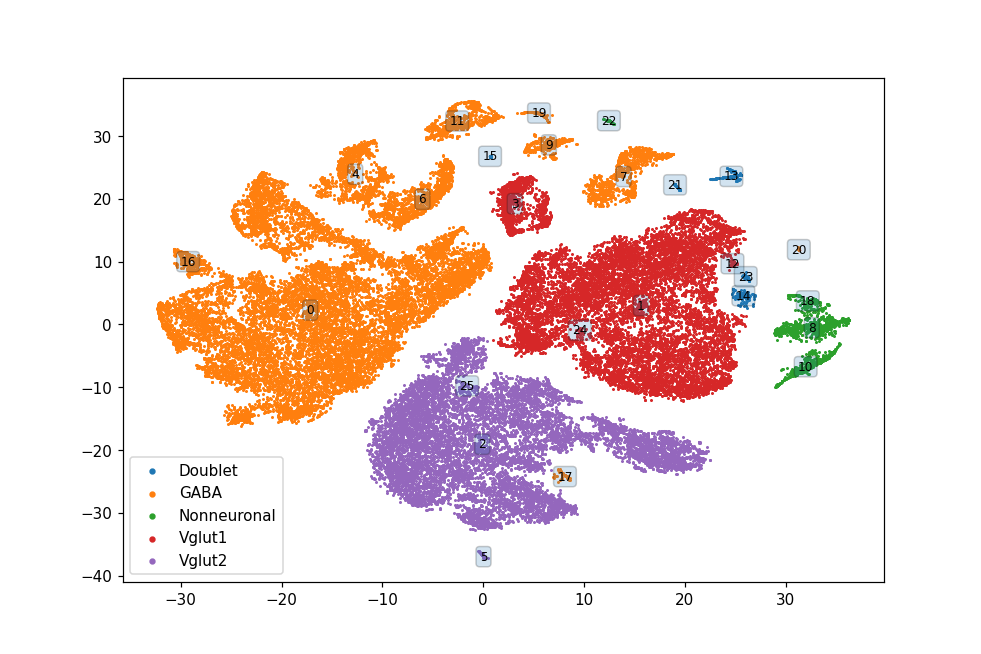

In [940]:
fig,ax = plt.subplots(figsize = (9,6))
for n, grp in arr_df_class.groupby('cell_class'):
    ax.scatter(x = 'tsne-1',y = 'tsne-2', data=grp, label=n, s = 1)
lgnd = ax.legend()
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

for label in set(labels):
    if label != -1:
        cluster_median = arr_xy[labels == label].median()
        #print (cluster_median)
        ax.annotate(text = label, xy=cluster_median, fontsize=8, color='black',
                    ha='center', va='center', bbox=dict(boxstyle='round', alpha=0.2))   
plt.show()

<IPython.core.display.Javascript object>


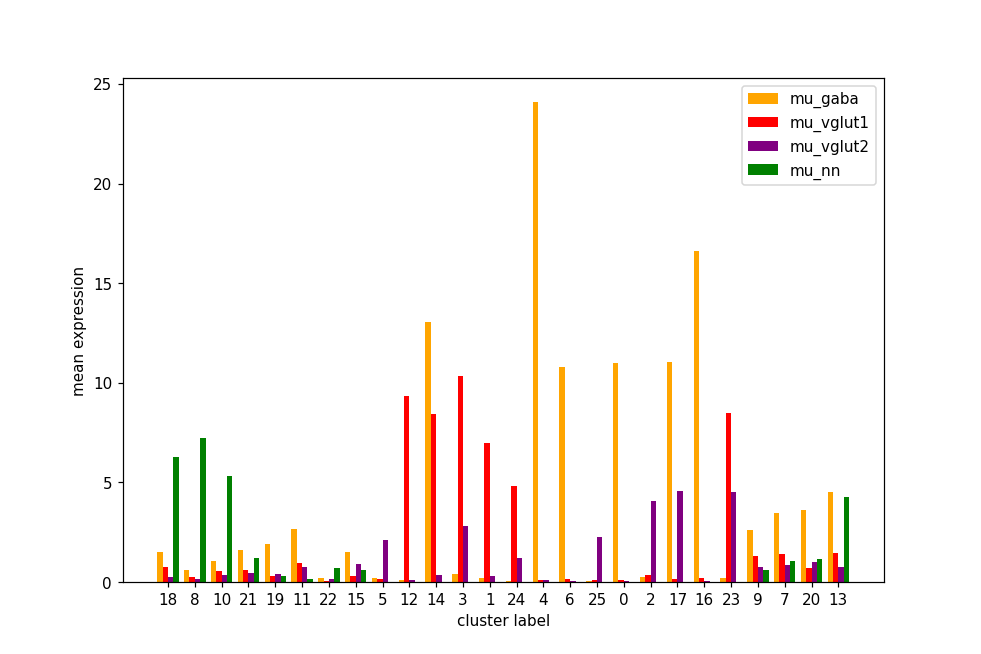

In [945]:
fig,ax = plt.subplots(figsize = (9,6))

x = linkage_cluster_order
xt =  np.arange(len(linkage_cluster_order))
plt.bar(xt-0.3,mu_g, width=0.2, color = 'orange', label = 'mu_gaba')
plt.bar(xt-.1, mu_vg1, width=0.2,color = 'red', label = 'mu_vglut1')
plt.bar(xt+0.1, mu_vg2, width = 0.2, color = 'purple', label = 'mu_vglut2')
plt.bar(xt+0.3, mu_nn, width = 0.2, color = 'green', label = 'mu_nn')
plt.legend()
plt.xlabel('cluster label')
plt.ylabel('mean expression')
plt.xticks(ticks = np.arange(len(linkage_cluster_order)),labels=linkage_cluster_order)
plt.show()

<IPython.core.display.Javascript object>


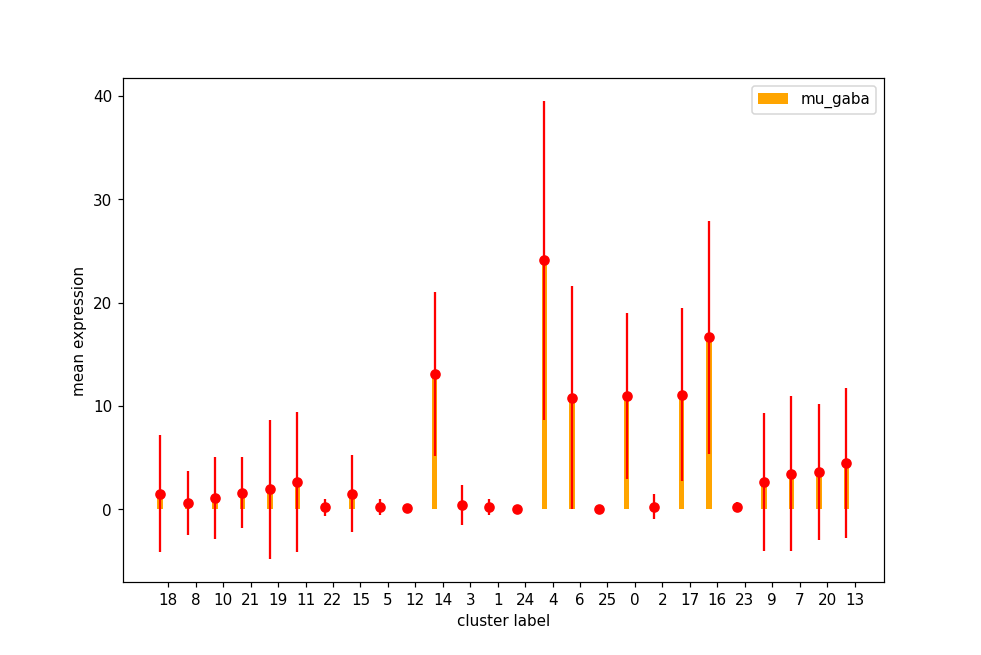

In [957]:
fig,ax = plt.subplots(figsize = (9,6))

x = linkage_cluster_order
xt =  np.arange(len(linkage_cluster_order))
plt.bar(xt-0.3,mu_g, width=0.2, color = 'orange', label = 'mu_gaba')
plt.errorbar(xt-0.3,mu_g, yerr=std_g, fmt="o", color="r")

plt.legend()
plt.xlabel('cluster label')
plt.ylabel('mean expression')
plt.xticks(ticks = np.arange(len(linkage_cluster_order)),labels=linkage_cluster_order)
plt.show()

In [942]:
linkage_cluster_order

array([18,  8, 10, 21, 19, 11, 22, 15,  5, 12, 14,  3,  1, 24,  4,  6, 25,
        0,  2, 17, 16, 23,  9,  7, 20, 13], dtype=int32)

In [875]:
GABA_marker

'Gad2'

In [884]:
Vglut1_marker

'Slc17a7'

array([-23.218868 ,  22.03602  ,   3.47782  , ..., -18.816036 ,
       -29.740122 ,   1.0558436], dtype=float32)

In [880]:
np.array(arr_df_class['tsne-2'])

array([ 19.077335  ,  11.704342  , -15.93463   , ...,  -0.29218698,
        -3.1720612 ,  -7.6662683 ], dtype=float32)

In [877]:
np.random.randn(10)

array([ 0.86802253, -0.84607469,  0.32646798, -1.35714726, -0.10816052,
       -1.85093742, -0.30616776, -1.0460263 , -0.67866644,  0.83745291])

In [969]:
df_s.shape

(744, 42764)

In [967]:
len(arr_df_class)

42764

In [996]:
df_pre_linkage_ls.shape

(42764, 744)

In [1002]:
df_marker.reindex(columns = )

CTTCTCTTCACAATGC-1_10X37_1  AATGGCTGTTGGCTAT-1_10X38_1  \
gene                                                              
Tagln                            20                           8   
Acta2                            36                          19   
Myh11                            31                           8   
Pln                               2                           1   
Gkn3                             28                           1   
...                             ...                         ...   
Cx3cr1                            0                           0   
Siglech                           0                           0   
Bcl2a1b                           0                           0   
Gpr34                             1                           0   
C1qb                              0                           0   

         ATGACCACACATTGTG-1_10X35_2  CTGCATCCAAATGGTA-1_10X52_3  \
gene                                                              
Tagln                             7                          24   
Acta2                            14                          27   
Myh11                             5                           2   
Pln                               6                           0   
Gkn3                             10                          13   
...                             ...                         ...   
Cx3cr1                            0                           0   
Siglech                           0                           0   
Bcl2a1b                           0                           0   
Gpr34                             0                           0   
C1qb                              0                           0   

         ACCAACACAGCTCGGT-1_10X37_1  CGAGAAGGTTCAGCGC-1_10X52_3  \
gene                                                              
Tagln                            20                          24   
Acta2                            64                          45   
Myh11                             7                          10   
Pln                              12                           2   
Gkn3                              5                           0   
...                             ...                         ...   
Cx3cr1                            0                           0   
Siglech                           0                           0   
Bcl2a1b                           0                           0   
Gpr34                             0                           0   
C1qb                              0                           0   

         TACTGCCGTCTCCCTA-1_10X38_1  TCATTTGAGCTGCGAA-1_10X37_1  \
gene                                                              
Tagln                            23                          18   
Acta2                            57                          48   
Myh11                             5                           4   
Pln                               2                           3   
Gkn3                             27                          23   
...                             ...                         ...   
Cx3cr1                            0                           0   
Siglech                           0                           0   
Bcl2a1b                           0                           0   
Gpr34                             0                           0   
C1qb                              0                           0   

         TTCGATTTCCATCTCG-1_10X38_1  GGTAGAGAGAGGATGA-1_10X37_2  ...  \
gene                                                             ...   
Tagln                            19                          43  ...   
Acta2                            41                          68  ...   
Myh11                            18                          22  ...   
Pln                               5                           3  ...   
Gkn3                             14                          14  ...   
...              

<IPython.core.display.Javascript object>


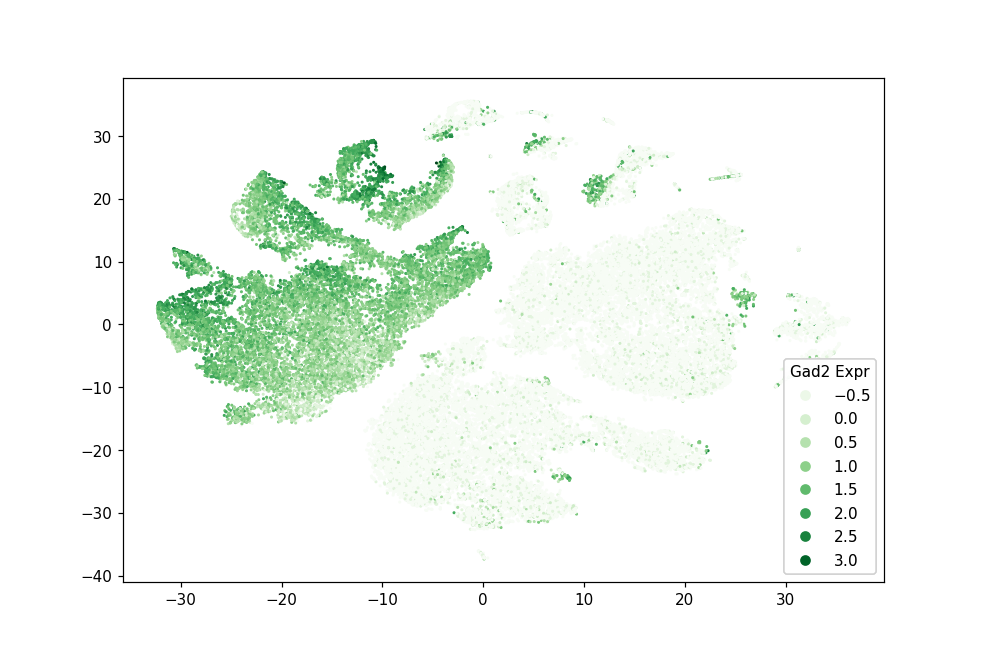

In [1033]:
x = np.array(arr_df_class['tsne-1'])
y = np.array(arr_df_class['tsne-2'])
z = np.array(df_pre_linkage_ls.T.loc[GABA_marker,:])

fig, ax = plt.subplots( figsize = (9,6))

scatter = ax.scatter(x, y, c = z , cmap = 'Greens' , s = 1)
legend = ax.legend(*scatter.legend_elements(), loc="lower right",
                   title="Gad2 Expr")
ax.add_artist(legend)
plt.show()

<IPython.core.display.Javascript object>


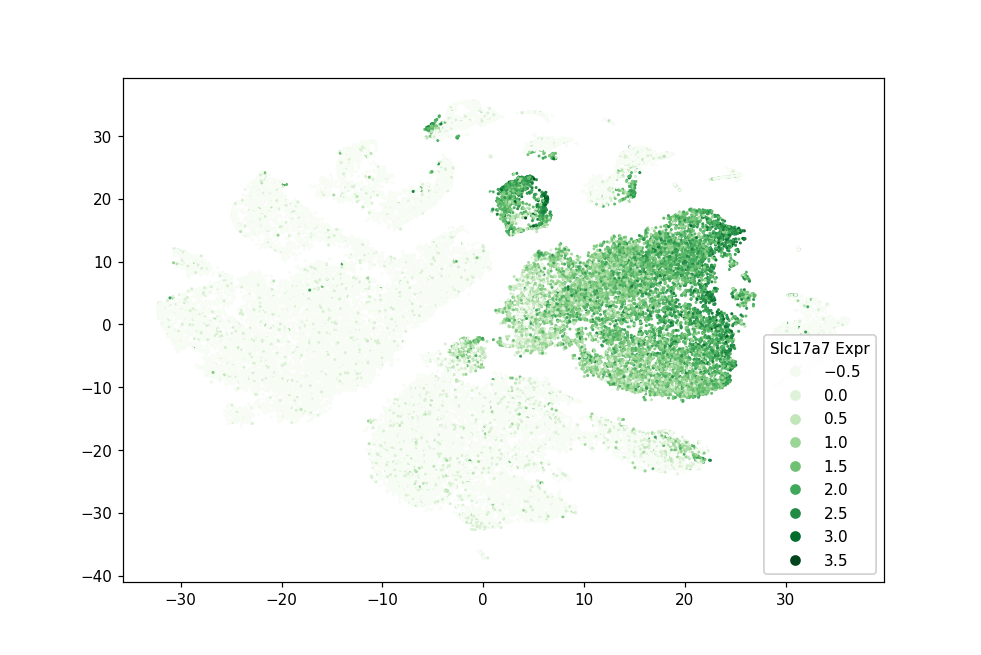

In [1026]:
x = np.array(arr_df_class['tsne-1'])
y = np.array(arr_df_class['tsne-2'])
z = np.array(df_pre_linkage_ls.T.loc[Vglut1_marker,:])

fig, ax = plt.subplots( figsize = (9,6))

scatter = ax.scatter(x, y, c = z , cmap = 'Greens' , s = 1)
legend = ax.legend(*scatter.legend_elements(), loc="lower right",
                   title="Slc17a7 Expr")
ax.add_artist(legend)
plt.show()

<IPython.core.display.Javascript object>


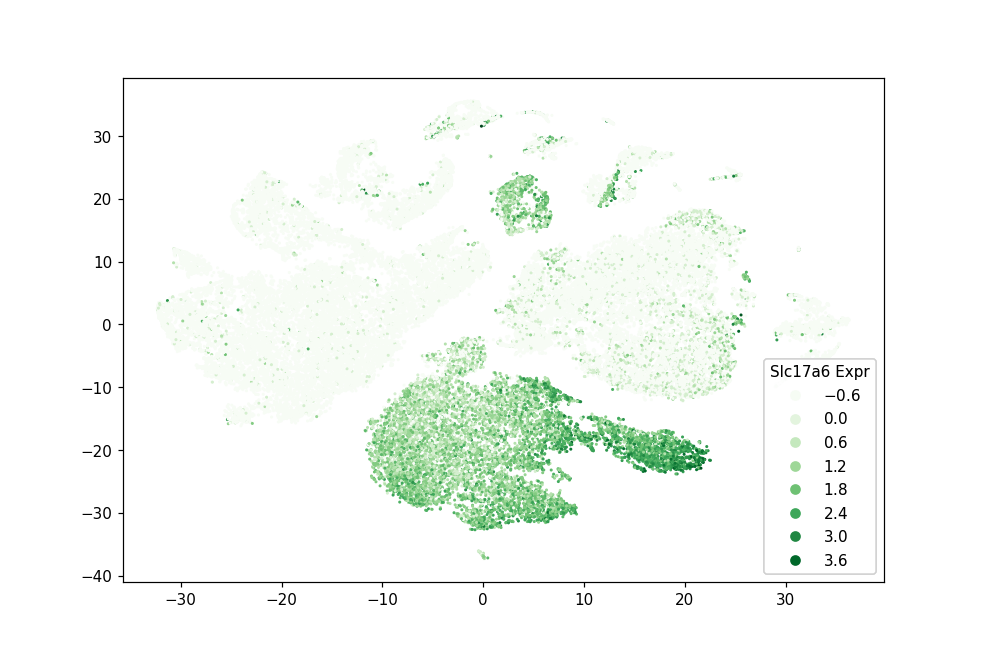

In [1027]:
x = np.array(arr_df_class['tsne-1'])
y = np.array(arr_df_class['tsne-2'])
z = np.array(df_pre_linkage_ls.T.loc[Vglut2_marker,:])

fig, ax = plt.subplots( figsize = (9,6))

scatter = ax.scatter(x, y, c = z , cmap = 'Greens' , s = 1)
legend = ax.legend(*scatter.legend_elements(), loc="lower right",
                   title="Slc17a6 Expr")
ax.add_artist(legend)
plt.show()

<IPython.core.display.Javascript object>


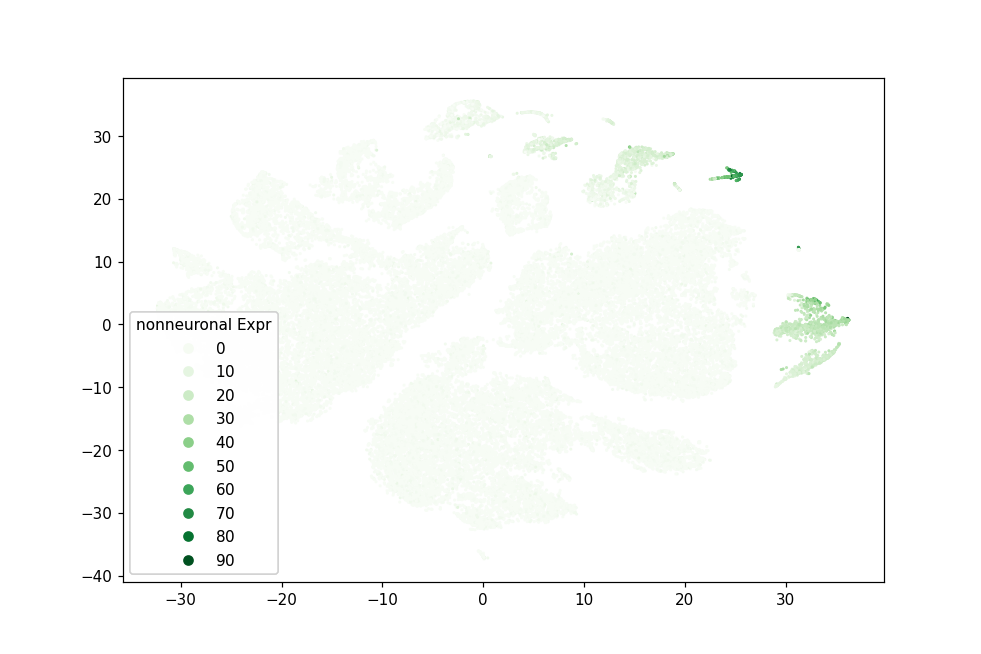

In [1031]:
x = np.array(arr_df_class['tsne-1'])
y = np.array(arr_df_class['tsne-2'])
z = nonneuro

fig, ax = plt.subplots( figsize = (9,6))

scatter = ax.scatter(x, y, c = z , cmap = 'Greens' , s = 1)
legend = ax.legend(*scatter.legend_elements(), loc="lower left",
                   title="nonneuronal Expr")
ax.add_artist(legend)

plt.show()

In [904]:
linkage_cluster_order

array([18,  8, 10, 21, 19, 11, 22, 15,  5, 12, 14,  3,  1, 24,  4,  6, 25,
        0,  2, 17, 16, 23,  9,  7, 20, 13], dtype=int32)

In [946]:
meta_data_df

CTTCTCTTCACAATGC-1_10X37_1  \
Serial_Number                                                        67.0   
Date_Captured                                                  2019-11-25   
Species                                                                Mm   
Transcriptome                                                        Mm10   
Strain                                                                      
Project                                                           Dimorph   
Group                                                             Naïve-M   
ChipID                                                              10X37   
SampleID                                                          10X37_1   
DonorID                                                           DI4,DI5   
Age                                                                  8.5w   
Num_Pooled_Animals                                                    2.0   
Sex                                                                     M   
Tissue                                                              MeA_L   
Cell_Conc                                                          1000.0   
Target_Num_Cells                                                   5000.0   
PCR_Cycles                                                           13.0   
Comments                Naive 8.5wo males, pooled, left hemisphere. 5%...   
cDNA_Lib_Ok                                                             Y   
ngperul_cDNA                                                         17.0   
Avesizebp_cDNAlib                                                           
Date                                                                        
cDNAul                                                                      
LIbConstructionComment                                                      
ngperul_seqlib                                                       15.9   
lengthbp_seqlib                                                     440.0   
Sample_Index                                                           E9   
cluster_label                                                          18   
cell_class                                                    Nonneuronal   

                                        AATGGCTGTTGGCTAT-1_10X38_1  \
Serial_Number                                                 69.0   
Date_Captured                                           2019-12-01   
Species                                                         Mm   
Transcriptome                                                 Mm10   
Strain                                                               
Project                                                    Dimorph   
Group                                                      Naïve-F   
ChipID                                                       10X38   
SampleID                                                   10X38_1   
DonorID                                                        DI6   
Age                                                             9w   
Num_Pooled_Animals                                             1.0   
Sex                                                              F   
Tissue                                                       MeA_L   
Cell_Conc                                                   1000.0   
Target_Num_Cells                                            5000.0   
PCR_Cycles                                                    13.0   
Comments                Naive 9wo female, left hemisphere. 5%opti.   
cDNA_Lib_Ok                                                      Y   
ngperul_cDNA                                                  21.9   
Avesizebp_cDNAlib                                           1870.0   
Date                                                                 
cDNAul                                                               
LIbConstructionComment                                  

Write to file

In [947]:
#outfile_name = 'df_marker_170424'
#df_marker.to_feather('/bigdata/isaac/'+outfile_name+'.feather')
#outfile_name = 'metadata_df_marker_170424'
#meta_data_df.to_json('/bigdata/isaac/'+outfile_name+'.json')